### Predgovor
Ova vježba sastoji se od teoretskog i praktičnog dijela. Bez adekvatnog teorijskog razumijevanja, izvedba vježbe biti će značajno izazovnija.

Predlažemo da napravite kopiju ove bilježnice na svoj Colab profil i tamo riješite vježbu. Ne zaboravite uključiti GPU akceleraciju (Runtime->Change runtime type->GPU->Save). \

U slučaju nejasnoća javite se na anja.delic@fer.hr.

# 4. Laboratorijska vježba - generativno modeliranje

Jedan od glavnih katalizatora u razvoju modernog računalnog vida jest dostupnost velikih skupova podataka. Iako su skupovi podataka lako dostupni, proces koji generira podatke je često nepoznat. Cilj ove laboratorijske vježbe jest pokušati aproksimirati proces koji generira dani skup podataka.


## Teorijska podloga generativnom modeliranju

Krenuti ćemo od bolje definicije zadatka.
Pretpostavimo postojanje skupa podataka $D=\{\mathbf{x}_i\}_{i=1}^N$ koji je nastao uzorkovanjem nepoznate distribucije $P_D(\underline{\mathbf{x}})$. Nadalje, pretpostavimo da je svaki primjer $\mathbf{x}_i$ dobiven nezavisnim uzorkovanjem. Naš cilj je aproksimirati nepoznatu distribuciju podataka $P_D(\underline{\mathbf{x}})$ poznatim modelom $P_\theta(\underline{\mathbf{x}})$.
S obzirom da su naši podaci često u kontinuirani ($\underline{\mathbf{x}}$ je kontinuirana slučajna varijabla) baviti ćemo se modeliranjem gustoća vjerojatnosti $p_D(\underline{\mathbf{x}})$ i $p_\theta(\underline{\mathbf{x}})$.

**Problem 1.:** Kako poravnati nepoznati $p_D(\underline{\mathbf{x}})$ i poznati $p_\theta(\underline{\mathbf{x}})$?



U teoriji vjerojatnosti, različitost između dvije distribucije $P(\underline{x})$ i $Q(\underline{x})$ se mjeri pomoću f-divergencije. Jedna od najčešćih mjera iz obitelji f-divergencija je KL-divergencija. KL-divergenciju za kontinuirane slučajne varijable definiramo kao:
$$
\mathrm{KL}(P, Q) = \int_{-\infty}^{+\infty} p(x) \ln\frac{p(x)}{q(x)} dx.
$$
$p$ i $q$ su pripadajuće gustoće vjerojatnosti.

KL-divergencije između distribucije podataka i distribucije modela je primamljiv gubitak za naš optimizacijski postupak. Može se pokazati da je minimizacija KL divergencije između distribucije podataka i distribucije modela ekvivalentna minimizaciji negativne log-izglednosti skupa podataka za učenje:
$$
\underset{\theta}{\mathrm{min}} \, \mathrm{KL}(p_D, p_\theta) \simeq \underset{\theta}{\mathrm{min}} \, -\mathbb{E}_{\mathbf{x} \in D} \;\;  [\ln p_\theta(\mathbf{x})]
$$

**Zadatak 1.**: Dokažite navedenu tvrdnju.

Dokaz:
$$
\mathrm{KL}(p_D, p_\theta) = \int_{-\infty}^{+\infty} p_D(x) \ln\frac{p_D(x)}{p_θ(x)} dx.
$$

$$
\mathrm{KL}(p_D, p_\theta) = \int_{-\infty}^{+\infty} p_D(x) \ln{p_D(x)} dx - \int_{-\infty}^{+\infty} p_D(x) \ln{p_θ(x)} dx.
$$

$$
\underset{\theta}{\mathrm{min}} \, \mathrm{KL}(p_D, p_\theta) = 0 - \underset{\theta}{\mathrm{max}}\int_{-\infty}^{+\infty} p_D(x) \ln{p_θ(x)} dx.
$$

$$
\underset{\theta}{\mathrm{min}} \, \mathrm{KL}(p_D, p_\theta) \simeq \underset{\theta}{\mathrm{min}} \, -\mathbb{E}_{\mathbf{x} \in D} \;\;  [\ln p_\theta(\mathbf{x})]
$$


**Problem 2.**: Definicija modela $p_\theta$.

Naš sljedeći korak je definirati model $p_\theta$. Upravo po definiciji  $p_\theta$ razlikujemo različite generativne modele.
Na primjer autoregresivna faktorizacija modela dovodi do autoregresijskih modela, dok modeliranje nenormalizirane distribucije dovodi do energijskih modela. U ovoj vježbi se fokusiramo  na vrstu generativnih modela koje nazivamo normalizirajući tokovi. Normalizirajući tok $p_\theta$ definiramo pomoću formule za zamjenu varijabli distribucije.

Pretpostavimo da su $\underline{\mathbf{x}}$ i $\underline{\mathbf{z}}$ dvije kontinuirane slučajne varijable. Pretpostavimo da bijekcija $f$ mapira realizacije slučajne varijable $\underline{\mathbf{x}}$ u realizacije od $\underline{\mathbf{z}}$, to jest $\mathbf{z} = f(\mathbf{x})$. S obzirom da je $f$ bijekcija vrijedi i obrat $\mathbf{x} = f^{-1}(\mathbf{z})$. Formulu za zamjenu varijabi distribucije definiramo kao:
$$
 p(\mathbf{x}) = q(\mathbf{z}) \left| \mathrm{det} \frac{\partial \mathbf{z}}{ \partial \mathbf{x}} \right|, \quad \mathbf{z} = f(\mathbf{x})
$$
$\frac{∂ \mathbf{z}}{ ∂ \mathbf{x}}$ predstavlja Jakobijan funkcije $f$ za $\textbf{x}$. det predstavlja determinantu. $|\cdot|$ predstavlja apsolutnu vrijednost.
To jest, drugi član umnoška odgovara apsolutnoj vrijednosti determinante Jakobijana transformacije $f$.

Formulu za zamjenu varijabli ćemo iskoristiti za izgradnju okvira koji nam omogućava implementaciju dubokog generativnog modela.
Ideja je jednostavna, distribuciju $q(\mathbf{z})$ možemo predefinirati (npr. kao Gaussovu distribuciju). Tada nam je jedina nepoznanica bijekcija $f$ koju možemo parametrizirati s $\theta$ te naučiti optimizacijskim postupkom.


Prisjetimo se sljedećih teorema:
1. kompozicija bijekcija je bijekcija, tj $f$ možemo raspisati kao $f = f_1 ∘ f_2 ∘ f_3 ∘ \dots \circ f_K$.
2. pravilo ulančavanja: $\frac{∂ z_3}{ ∂ z_1} = \frac{∂ z_3}{ ∂ z_2}\frac{∂ z_2}{ ∂ z_1} $
3. determinanta umnoška dviju kvadratnih matrica istog reda jednaka je umnošku determinanti svake matrice (Binet-Cauchyjev teorem)
4. Apsolutna vrijednost umnoška dva realna broja je jednaka umnošku apsolutnih vrijednosti: $|a\cdot b| = |a|\cdot |b|$

Bijekciju $f$ možemo promatrati kao kompoziciju funkcija, gdje svaka funkcija $f_i$ prima varijablu $z_{i-1}$ i računa varijablu $z_i$.
Ako uzmemo u obzir prethodno spomenute teoreme, dolazimo do sljedeće formulacije:
$$
 p_\theta (\mathbf{x}) = q(\mathbf{z}_K) \prod_{k=1}^K \left| \mathrm{det} \frac{\partial \mathbf{z}_{k} }{ \partial \mathbf{z}_{k-1}} \right|, \quad \mathbf{z}_{k} = f_{\theta_k}(\mathbf{z}_{k-1}),
$$
gdje je $\mathbf{z}_{0} = \mathbf{x}$.
$q(\mathbf{z}_K)$ može biti proizvoljna distribucija pa je definiramo kao $q(\mathbf{z}_K):= \mathcal{N}(\mathbf{z}_K; 0, \mathrm{I})$.

**Zadatak 2.** Krenuvši od općenite formule za zamjenu varijabli izvedite izraz za normalizirajući tok.

Izvod:
$$
p(\mathbf{x}) = q(\mathbf{z}_K) \left| \mathrm{det} \frac{\partial f(\mathbf{x})}{ \partial \mathbf{x}} \right| \\
$$

Iterativno primjenom $$ {z}_{k} = f_{\theta_k}(\mathbf{z}_{k-1}) $$ i $$ z_0 = x $$ jer je $f = f_1 ∘ f_2 ∘ f_3 ∘ \dots \circ f_K$ stoga se dobi produkt.

$$
 p_\theta (\mathbf{x}) = q(\mathbf{z}_K) \prod_{k=1}^K \left| \mathrm{det} \frac{\partial \mathbf{z}_{k} }{ \partial \mathbf{z}_{k-1}} \right|, \quad \mathbf{z}_{k} = f_{\theta_k}(\mathbf{z}_{k-1}),
$$

Spomenimo još da nas općenito zanima logaritam gustoće vjerojatnosti pa pišemo:
$$
 \ln p_\theta (\mathbf{x}) = \ln q(\mathbf{z}_K) +\sum_{k=1}^K \ln \left| \mathrm{det} \frac{\partial \mathbf{z}_{k} }{ \partial \mathbf{z}_{k-1}} \right|, \quad \mathbf{z}_{k} = f_{\theta_k}(\mathbf{z}_{k-1}), \tag{1}
$$

Ostala nam je još jedna nepoznanica, a to je dizajn funkcija $f_k$,  $k=1,...,K$.
Dizajn funkcije f ovisi o podacima koje modeliramo. Razmislite kako biste bijekciju modelirali kao gradivni blok dubokog modela.

## Modeliranje 2D skupa podataka normalizirajućim tokom

**Problem 3.** Modeliranje 2D skupa podatka.

In [176]:
import torch
import random
import numpy as np
import torch.nn as nn

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

import matplotlib.pyplot as plt

In [177]:
class GaussianMixture2DDataset:
    def __init__(self, num_samples, n_comp=2, loc=torch.zeros(2,2), scale=torch.ones(2,2), pi=(torch.ones(2)/2)):
        samples_per_component = (pi * num_samples).long()
        self.samples = torch.cat([torch.randn(samples_per_component[i],2) * scale[i] + loc[i] for i in range(n_comp)], 0)

    def __getitem__(self, idx):
        return self.samples[idx]

Promotrimo sljedeći skup podataka. Pretpostavimo da nam je dostupan samo skup podataka $D$. Cilj nam je aproksimirati distribuciju podataka $p_D$ pomoću normalizirajućeg toka.

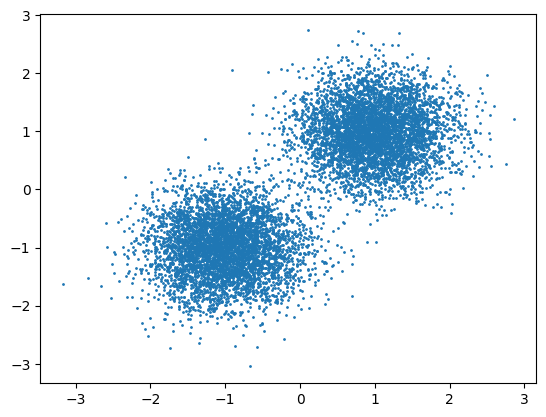

In [178]:
D = GaussianMixture2DDataset(9999, loc=torch.tensor([[-1, -1], [1,1]]), scale=torch.tensor([[0.5, 0.5], [0.5,0.5]])).samples
plt.scatter(D[:, 0], D[:, 1], 1)
plt.show()

S obzirom da modeliramo 2D skup podatka, zanimaju nas funkcije s domenom $\mathbb{R}^2$ i kodomenom $\mathbb{R}^2$ koje imaju inverz.
Definiramo sljedeći implementacijski ovir:

In [179]:
class _Bijection(nn.Module):
    def __init__(self):
        super(_Bijection, self).__init__()

    def forward(self, x):
        pass

    def inverse(self, z):
        pass

Funkcija `forward` implementira unaprijedni prolaz kroz sloj i na izlazu vraća transformirani ulaz i logaritam apsolutne vrijednosti determinante Jakobijana funkcije. \
Funkcija `inverse` implementira inverzni probalz kroz sloj i na izlazu vraća transformirani ulaz.

**Zadatak 3.**: Pokušajmo ponuditi bijektivnu alternativu sloju torch.nn.Linear za dvodimenzionalne podatke. Obratite pozornost na to da je transformaciju potrebno održavati invertibilnom regularizacijskim članom.
Nadopunite forward i inverse funkciju.

Uputa: Linearna transformacija se primjenjuje na svaki primjer u minigrupi nezavisno. Zbog malene dimenzionalnosti, invertiranje i računanje determinante Jakobijana možemo izvesti grubom silom, izravnim pozivom odgovarajućih funkcija torcha.

In [180]:
def sum_except_batch(x, num_dims=1):
    return x.reshape(*x.shape[:num_dims], -1).sum(-1)

class BijectiveLinear2D(_Bijection):
    def __init__(self, dim):
        super(_Bijection, self).__init__()
        self.dim = dim
        self.weight = nn.Parameter(torch.eye(dim))
        self.bias = nn.Parameter(torch.zeros(1, dim))

    def forward(self, x):   # x has shape NxD
        z = x @ self.weight + self.bias
        log_abs_det = torch.log(torch.abs(torch.det(self.weight)))
        log_abs_det = sum_except_batch(log_abs_det[None, ...].repeat(x.shape[0], 1))
        return z, log_abs_det # shapes NxD, N

    def inverse(self, z):
        x = (z - self.bias) @ torch.inverse(self.weight)
        return x    # NxD

    def regularization(self):
        return ((self.weight @ self.weight) - torch.eye(self.dim)).abs().sum()




**Zadatak 4.**: Nadopunjavanje izvedbe osnovnog razreda `NormalizingFlow`.

Proučite predloženu nepotpunu izvedbu razreda `NormalizingFlow`. Obratite pozornost na to da konstruktor razreda prima argument `transforms` koji mora biti tipa [torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) kako bismo kroz taj objekt mogli iterirati pri unaprijednom i inverznom prolazu. Iteraciju ćemo provoditi `for` petljom i tako prolaziti kroz slojeve normalizirajućeg toka. Predložite potpunu izvedbu razreda `NormalizingFlow` pod pretpostavkom da svi elementi slijednog modela `transforms` nasljeđuju prethodno definirano sučelje `_Bijection`. Vaše rješenje može dodavati nove lokalne metode razredu `NormalizingFlow`.



In [181]:
class NormalizingFlow(nn.Module):
    """
    Base class for normalizing flow.
    """

    def __init__(self, transforms, input_dim, device="cpu"):
        super(NormalizingFlow, self).__init__()
        self.transforms = transforms # has to be of type nn.Sequential.
        self.device = device
        self.register_buffer('loc', torch.zeros(input_dim).to(device))
        self.register_buffer('log_scale', torch.zeros(input_dim).to(device))
        self.base_dist = torch.distributions.Normal(self.loc.to(device), torch.exp(self.log_scale).to(device))

    def forward_with_log(self, x):
        """Transforms the input sample to the latent representation z.

        Args:
            x (torch.Tensor): input sample

        Returns:
            torch.Tensor: latent representation of the input sample
        """
        z = x
        log_abs_det = torch.zeros(x.shape[0]).to(x.device)
        for transform in self.transforms:
            z, lad = transform.forward(z)
            log_abs_det += lad
        return z, log_abs_det

    def forward(self, x):
        """Transforms the input sample to the latent representation z.

        Args:
            x (torch.Tensor): input sample

        Returns:
            torch.Tensor: latent representation of the input sample
        """
        z, _ = self.forward_with_log(x)
        return z

    def inverse(self, z):
        """Transforms the latent representation z back to the input space.

        Args:
            z (torch.Tensor): latent representation

        Returns:
            torch.Tensor: representation in the input space
        """
        x = z
        for transform in reversed(self.transforms):
            x = transform.inverse(x)
        return x

    def log_prob(self, x):
        """Calculates the log-likelihood of the given sample x (see equation (1)).

        Args:
            x (torch.Tensor): input

        Returns:
            torch.Tensor: log-likelihood of x
        """
        z, log_abs_det = self.forward_with_log(x)
        log_pz = self.base_dist.log_prob(z).sum(dim=1)
        log_px =  log_pz + log_abs_det
        return log_px

    def sample(self, num_samples, T=1):
        """Generates new samples from the normalizing flow.

        Args:
            num_samples (int): number of samples to generate
            T (float, optional): sampleing temperature. Defaults to 1.

        Returns:
            torch.Tensor: generated samples
        """
        z = self.base_dist.sample(torch.Size([num_samples])) * T
        x = self.inverse(z)
        return x

U jednostavnom slučaju, transformaciju normalizirajućeg toka možemo definirati kao slijed linearnih transformacija:

In [182]:
class SimpleNF(NormalizingFlow):
    def __init__(self, input_dim, num_steps=2):
        transforms = nn.Sequential()
        for _ in range(num_steps):
            transforms.append(BijectiveLinear2D(input_dim))

        super(SimpleNF, self).__init__(transforms=transforms, input_dim=input_dim)

    def gather_regularization(self):
        return sum([m.regularization() for m in self.transforms])

Provjerite svoju implementaciju inverza sljedećim kodom:

In [183]:
flow = SimpleNF(2, num_steps=7)
print((flow.inverse(flow(D)) - D).sum().item())
assert (flow.inverse(flow(D)) - D).sum() < 1e-9

0.0


Tok učimo optmizacijom prethodno objašnjenog gubitka.

In [184]:
flow = SimpleNF(2, num_steps=7)
optim = torch.optim.SGD(flow.parameters(), lr=1e-1)

for iter in range(4000):
    optim.zero_grad()
    log_px = flow.log_prob(D)
    loss = - (log_px).mean()
    loss_reg = flow.gather_regularization()
    total_loss = loss + 0.001 * loss_reg
    total_loss.backward()
    optim.step()
    if iter % 20 == 0:
        print(f"Iter {iter+1}: Loss:{loss.item()} Reg:{loss_reg.item()}")

Iter 1: Loss:3.0862061977386475 Reg:0.0
Iter 21: Loss:2.5466420650482178 Reg:3.069652795791626
Iter 41: Loss:2.5820398330688477 Reg:3.0877668857574463
Iter 61: Loss:2.5494747161865234 Reg:3.197514533996582
Iter 81: Loss:2.5468552112579346 Reg:3.202148914337158
Iter 101: Loss:2.5466535091400146 Reg:3.198676347732544
Iter 121: Loss:2.5466349124908447 Reg:3.1947755813598633
Iter 141: Loss:2.546633005142212 Reg:3.1909635066986084
Iter 161: Loss:2.546633005142212 Reg:3.1872682571411133
Iter 181: Loss:2.546633005142212 Reg:3.1836867332458496
Iter 201: Loss:2.546633243560791 Reg:3.1802120208740234
Iter 221: Loss:2.546632766723633 Reg:3.176840305328369
Iter 241: Loss:2.546632766723633 Reg:3.173570156097412
Iter 261: Loss:2.5466325283050537 Reg:3.1703970432281494
Iter 281: Loss:2.5466325283050537 Reg:3.167318105697632
Iter 301: Loss:2.546632766723633 Reg:3.1643314361572266
Iter 321: Loss:2.546633243560791 Reg:3.161432981491089
Iter 341: Loss:2.546632766723633 Reg:3.1586203575134277
Iter 361: Lo

Ako ste do sada sve napravili kako treba, predloženi postav trebao bi uspjeti naučiti tok s gubitkom od oko 2.5.

Provjerimo još jednom stabilnost inverza. Kako biste komentrali rezultate?

In [185]:
print((flow.inverse(flow(D)) - D).sum())
assert (flow.inverse(flow(D)) - D).sum() < 1e-4

tensor(2.6807e-05, grad_fn=<SumBackward0>)


Normalizirajućim tokom možemo generirati primjere na sljedeći način:

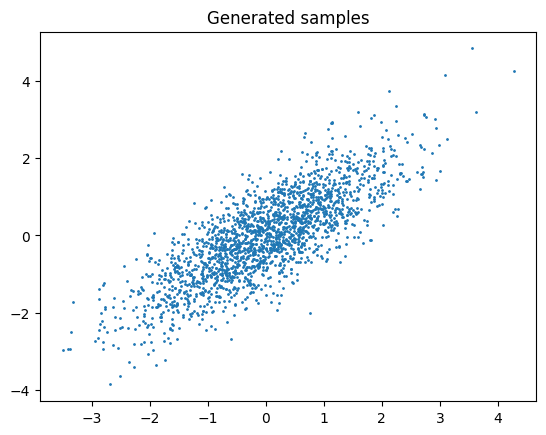

In [186]:
X_ = flow.sample(2000).detach()
plt.scatter(X_[:, 0], X_[:, 1], 1)
plt.title("Generated samples")
plt.show()

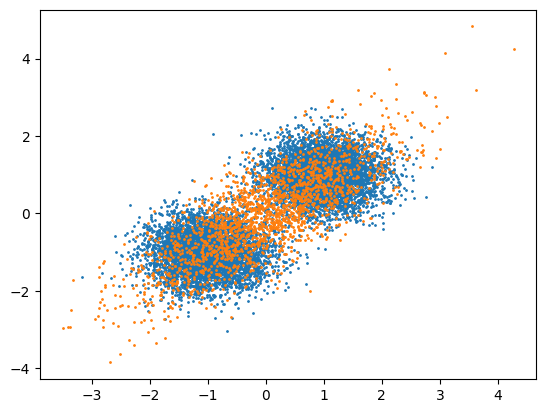

In [187]:
plt.clf()
plt.scatter(D[:, 0], D[:, 1], 1)
plt.scatter(X_[:, 0], X_[:, 1], 1)
plt.show()

Tok definiran razredom SimpleNF ne može ostvariti veliki kapacitet jer je kompozicija linearnih transformacija i dalje linearna transformacija. Stoga modelirana distribucija ne uspijeva dovoljno dobro aproksimirati $p_D$. Bolju aproksimaciju dobiti ćemo sofisticiranijom arhitekturom pod nazivom [RealNVP](https://arxiv.org/abs/1605.08803). RealNVP se sastoji od "slojeva" afinog miješanja koji su invertibilni po konstrukciji. Imajte na umu da afino miješanje tipično ostvarujemo s više slojeva dubokog modela jer modul miješanja `net` može sadržavati (i tipično sadrži) veći broj uzastopnih nelinearnih transformacija.

Unaprijedni prolaz kroz afino miješanje s ulazom $\mathbf{x}$ dimenzionalnosti $d$ definiramo kao ($m < d$):
$$
\mathbf{z}_{:m} = \mathbf{x}_{:m}
$$
$$
\mathbf{z}_{m:d} = \exp(\ln\mathbf{s}) \odot \mathbf{x}_{m:d} + \mathbf{t}, \quad \ln s, t = net(\mathbf{x}_{:m})
$$

**Zadatak 5.**: Skicirajte računske grafove unaprijednog i unatražnog prolaza kroz afino miješanje. \
Nadopunite predloženi razred `AffineCouplingLayer` s prikladnom funkcionalnošću.
Afino miješanje transformira samo polovicu ulaznog tezora $\mathbf{x}_{m:d}$, dok druga polovica $\mathbf{x}_{:m}$ ostaje nepromijenjena.
Modul miješanja `net` predviđa parametre miješanja `log_s` i `t` iz polovice ulaznog tenzora $\mathbf{x}_{:m}$.

In [188]:
class AffineCouplingLayer(_Bijection):
    def __init__(self, net):
        super(AffineCouplingLayer, self).__init__()
        self.net = net

    def forward(self, x): # NxD
        x_a, x_b = x.chunk(2, dim=1)
        log_s, t = self.net(x_a)
        s = torch.exp(log_s)
        z_b = x_b * s + t
        z = torch.cat([x_a, z_b], dim=1)
        log_det = sum_except_batch(log_s)
        return z, log_det # NxD , N

    def inverse(self, y): # NxD
        z_a, z_b = y.chunk(2, dim=1)
        log_s, t = self.net(z_a)
        s = torch.exp(log_s)
        x_b = (z_b - t) / s
        x = torch.cat([z_a, x_b], dim = 1)
        return x # NxD

**Zadatak 6.:** Zamislimo situaciju gdje slijedno primjenjujemo više coupling slojeva. Možemo primijetiti da će se miješati samo jedna polovica tenzora. Kako bismo osigurali da se miješaju obje polovice ulaznog tenzora, uvodimo transformaciju `SwitchSides` koju ćemo primijeniti nakon svakog coupling sloja.
Na taj način osiguravamo da miješanje provodimo naizmjenično na dvjema polovicama ulaznog tenzora. \
Tenzor dijelimo po dimenziji značajki. Dovršite implementaciju razreda `SwitchSides` tako da dijeli ulazni tenzor na dva dijela po dimenziji značajki i zamjenjuje im strane. Možete iskoristiti funkcije [chunk](https://pytorch.org/docs/stable/generated/torch.chunk.html) i [cat](https://pytorch.org/docs/stable/generated/torch.cat.html).

In [189]:
class SwitchSides(_Bijection):

    def forward(self, x):
        x_a, x_b = x.chunk(2, dim=1)
        y = torch.cat([x_b, x_a], dim=1)
        return y, 0.

    def inverse(self, z):
        z_a, z_b = z.chunk(2, dim=1)
        x = torch.cat([z_b, z_a], dim=1)
        return x

**Zadatak 7.:**U nastavku je dan razred `SimpleTransform` kojeg ćemo koristiti kao modul afinog miješanja u coupling sloju. Primijetite da će primjerci tog razreda biti atributi `net` razreda `AffineCouplingLayer`.\
Dovršite implementaciju tako da `model` bude potpuno povezani modul sljedeće arhitekture:

`fc(dim, internal_dim) -> relu -> fc(internal_dim, internal_dim) -> relu -> fc(internal_dim, 2*dim)`.

Dimenziju skrivenog sloja potpuno povezanog modula određujemo parametrom `inflate_coef`. \


Inicijalizirajte parametre modula miješanja tako da modul provodi transformaciju koja je jednaka identitetu. \

In [190]:
class SimpleTransform(nn.Module):
    def __init__(self, dim, inflate_coef=1):
        super(SimpleTransform, self).__init__()
        self.dim = dim
        internal_dim = int(dim * inflate_coef)
        self.model = nn.Sequential(
            nn.Linear(dim, internal_dim),
            nn.ReLU(),
            nn.Linear(internal_dim, internal_dim),
            nn.ReLU(),
            nn.Linear(internal_dim, 2*dim)
        )
        self.model[-1].weight.data.zero_()
        self.model[-1].bias.data.zero_()

    def forward(self, x):
        out = self.model(x)
        log_s, t = torch.chunk(out, dim=1, chunks=2)
        log_s = torch.clamp(log_s, -0.5, 0.5)
        return log_s, t

In [191]:
class SimpleRealNVP(NormalizingFlow):
    def __init__(self, input_dim, num_steps=2):
        transforms = nn.Sequential()
        for i in range(num_steps):
            transforms.append(AffineCouplingLayer(SimpleTransform(input_dim//2)))
            if i != num_steps - 1:
                transforms.append(SwitchSides())
        super(SimpleRealNVP, self).__init__(transforms, input_dim)


Tok možemo naučiti na način kako slijedi:

In [192]:
flow = SimpleRealNVP(2, num_steps=7)
optim = torch.optim.SGD(flow.parameters(), lr=1e-2, nesterov=True, momentum=0.9)

for iter in range(2000):
    optim.zero_grad()
    log_px = flow.log_prob(D)
    loss = - (log_px).mean()
    total_loss = loss
    total_loss.backward()
    optim.step()
    if iter % 20 == 0:
        print(f"Iter {iter+1}: Loss:{loss.item()}")

Iter 1: Loss:3.0862061977386475
Iter 21: Loss:3.053637981414795
Iter 41: Loss:3.0354361534118652
Iter 61: Loss:2.959836006164551
Iter 81: Loss:2.6046385765075684
Iter 101: Loss:2.504342555999756
Iter 121: Loss:2.4966273307800293
Iter 141: Loss:2.494203805923462
Iter 161: Loss:2.4923267364501953
Iter 181: Loss:2.490591287612915
Iter 201: Loss:2.488844394683838
Iter 221: Loss:2.486994743347168
Iter 241: Loss:2.4849636554718018
Iter 261: Loss:2.4827239513397217
Iter 281: Loss:2.4802989959716797
Iter 301: Loss:2.477782726287842
Iter 321: Loss:2.475313901901245
Iter 341: Loss:2.4730141162872314
Iter 361: Loss:2.4709665775299072
Iter 381: Loss:2.4690704345703125
Iter 401: Loss:2.467123031616211
Iter 421: Loss:2.4649832248687744
Iter 441: Loss:2.4627420902252197
Iter 461: Loss:2.460517406463623
Iter 481: Loss:2.45831036567688
Iter 501: Loss:2.4561641216278076
Iter 521: Loss:2.454165458679199
Iter 541: Loss:2.4524893760681152
Iter 561: Loss:2.4512009620666504
Iter 581: Loss:2.4504246711730957


In [193]:
print((flow.inverse(flow(D)) - D).sum())
assert (flow.inverse(flow(D)) - D).sum() < 1e-3

tensor(0.0002, grad_fn=<SumBackward0>)


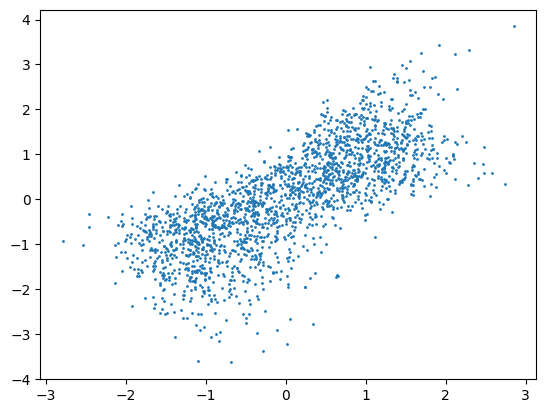

In [194]:
X_ = flow.sample(2000, 1).detach()
plt.scatter(X_[:, 0], X_[:, 1], 1)
plt.show()

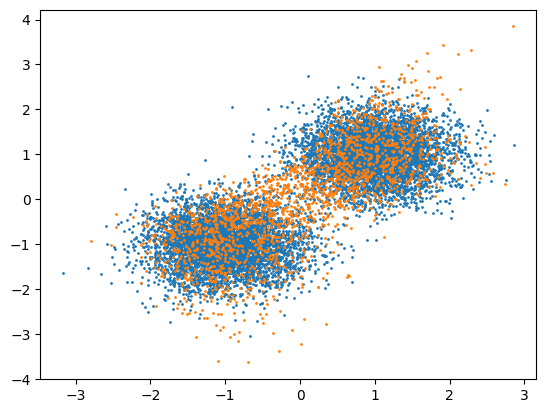

In [195]:
plt.clf()
plt.scatter(D[:, 0], D[:, 1], 1)
plt.scatter(X_[:, 0], X_[:, 1], 1)

Kao što vidite, kapacitetniji tok uspijeva dobro aproksimirati dani skup podataka.

## Modeliranje slika normalizirajućim tokom

Naš sljedeći zadatak je modelirati distribuciju slika s normalizirajućim tokom. Slike možemo prestaviti diskretnim tenzorom $\mathbf{x} \in [0, 255]^{C \times H \times W}$. Prisjetimo se da smo normalizirajući tok definirali za kontinuirane slučajne varijable. Stoga, potrebno je transfrormirati skup podataka u kontinuiranu domenu pomoću zašumljivanja:

$$
\mathbf{y} = \mathbf{x} + \mathbf{u}, \quad \mathbf{u} \sim \mathrm{U}[0, 1)
$$
U prestavlja uniformnu razdiobu. Sada, naš model uči modelirati zašumljenu sliku. Više o dekvantizaciji zašumljivanjem možete pronaći [ovdje](https://arxiv.org/pdf/1511.01844.pdf).

MNIST je skup jednostavnih slika pa ćemo se sljedećim pojednostavljenjem. Sliku ćemo ispeglati u vektor i normalizirajućim tokom učiti takvu reprezentaciju slike.

U nastavku je dan kod za pripremanje skupa slika.

In [196]:
from torchvision.datasets import MNIST
import torchvision.transforms as tf
from torch.utils.data import DataLoader, Subset

In [197]:
train_ds = MNIST('.', train=True, download=True, transform=tf.Compose([tf.Resize(14), tf.ToTensor()]))
test_ds = MNIST('.', train=False, download=True, transform=tf.Compose([tf.Resize(14), tf.ToTensor()]))

selected_number = 0

indices = [r[0] for r in list(filter(lambda x: x[1] == selected_number ,[(i, train_ds[i][1]) for i in range(len(train_ds))]))]
train_ds = Subset(train_ds, indices)

indices = [r[0] for r in list(filter(lambda x: x[1] == selected_number ,[(i, test_ds[i][1]) for i in range(len(test_ds))]))]
test_ds = Subset(test_ds, indices)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

In [198]:
def plot_mnist(samples, num_row, num_col):
    assert len(samples) ==  num_row * num_col
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(len(samples)):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(samples[i], cmap='gray')
    plt.tight_layout()
    plt.show()

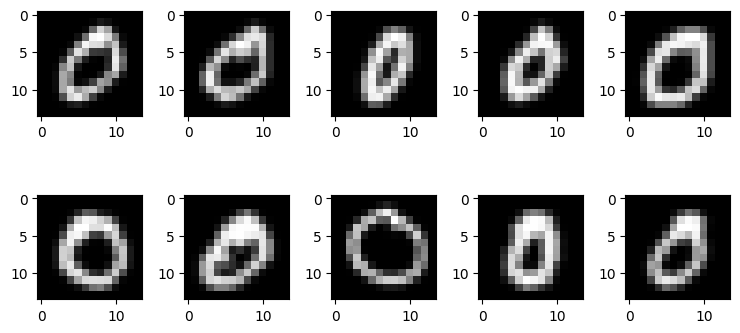

In [199]:
samples = [train_ds[i][0][0] for i in range(10)]
plot_mnist(samples, 2, 5)

**Zadatak 8.:** Predložite arhitekturu toka koji će moći naučiti distribuciju vektoriziranih slika. Predlažemo koristiti rezidualni blok sljedeće arhitekture.

`fc(dim, dim) -> BN -> relu -> fc(dim, dim) -> relu`

Potrebno je dodati rezidualnu vezu od ulaza u rezidualni blok do latentne reprezentacije prije posljednje zglobnice.
Dovršite implementaciju i validirajte utjecaj batchnorma na proces učenja i konačne rezultate.

In [200]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, use_bn=False):
        super(ResidualBlock, self).__init__()
        self.f_relu = nn.ReLU()
        self.layers = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim) if use_bn else nn.Identity(),
            nn.ReLU(),
            nn.Linear(dim, dim),
            nn.ReLU()
        )


    def forward(self, x):
        identity = x
        out = self.layers(x)
        out = out + identity
        return self.f_relu(out)

**Zadatak 9.:** Po uzoru na razred `SimpleTransform` dovršite implementaciju razreda `SimpleResidualTransform` čiji se modul miješanja sastoji od rezidualnih blokova. Predlažemo sljedeću arhitekturu:

`fc(dim, internal_dim) -> relu -> res_block(internal_dim, internal_dim) -> fc(internal_dim, 2*dim)`

Eksperimentirajte s brojem rezidualnih blokova. Kako broj rezidualnih blokova utječe na rezultate?

In [201]:
class SimpleResidualTransform(nn.Module):
    def __init__(self, dim, inflate_coef=1):
        super(SimpleResidualTransform, self).__init__()
        self.dim = dim
        internal_dim = int(dim * inflate_coef)
        self.model = nn.Sequential(
            nn.Linear(dim, internal_dim),
            nn.ReLU(),
            ResidualBlock(internal_dim),
            nn.Linear(internal_dim, 2*dim)
        )
        self.model[-1].weight.data.zero_()
        self.model[-1].bias.data.zero_()

    def forward(self, x):
        out = self.model(x)
        log_s, t = torch.chunk(out, dim=1, chunks=2)
        log_s = torch.clamp(log_s, -2, 2)
        return log_s, t

**Zadatak 10.:** Dovršte implementaciju razreda `RealNVP` po uzoru na `SimpleRealNVP`. `RealNVP` treba koristiti `SimpleResidualTransform` umjesto `SimpleTransform` kao modul miješanja.

In [202]:
class RealNVP(NormalizingFlow):
    def __init__(self, input_dim, num_steps=2, device="cuda"):
        transforms = nn.Sequential()
        for i in range(num_steps):
            transforms.append(AffineCouplingLayer(SimpleResidualTransform(input_dim//2)))
            if i != num_steps - 1:
                transforms.append(SwitchSides())
        super(RealNVP, self).__init__(transforms, input_dim, device=device)

U nastavku je kod za učenje toka.

Obratite pozornost na to da izglednost slike prikazujemo u bitovima po dimenziji (BPD). Podsjetite se što ta mjera predstavlja i kako ju računamo.

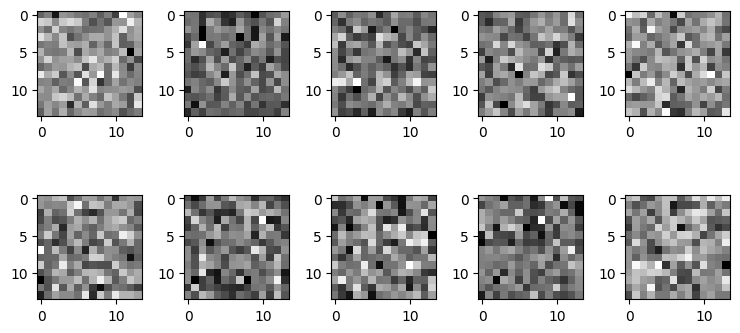

Epoch 1: Train Loss:1271.803425241024 Val BPD: 9.312201499938965


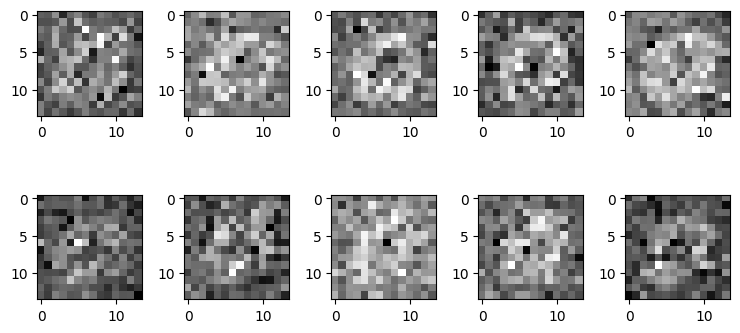

Epoch 11: Train Loss:1041.11658623878 Val BPD: 7.596751689910889


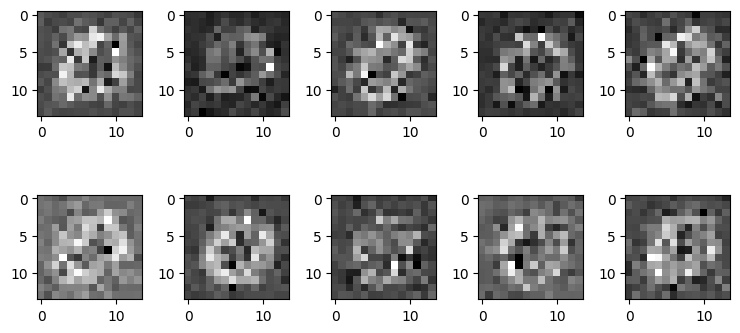

Epoch 21: Train Loss:858.1858338700964 Val BPD: 6.276827335357666


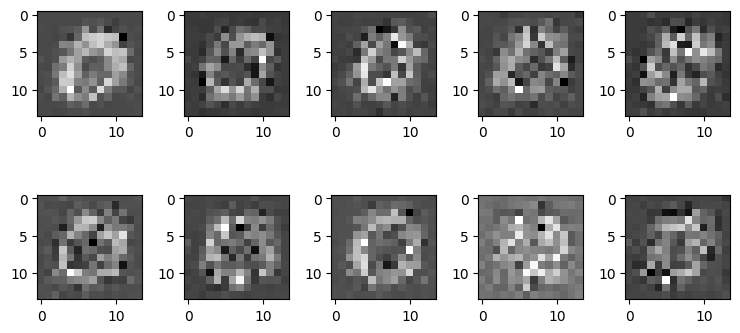

Epoch 31: Train Loss:750.1643248213098 Val BPD: 5.500605583190918


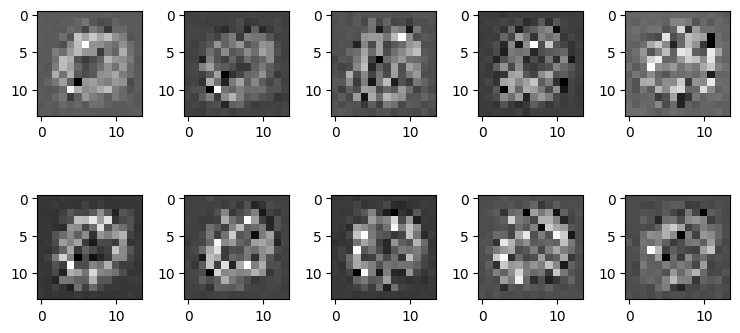

Epoch 41: Train Loss:698.3021629820479 Val BPD: 5.140190124511719


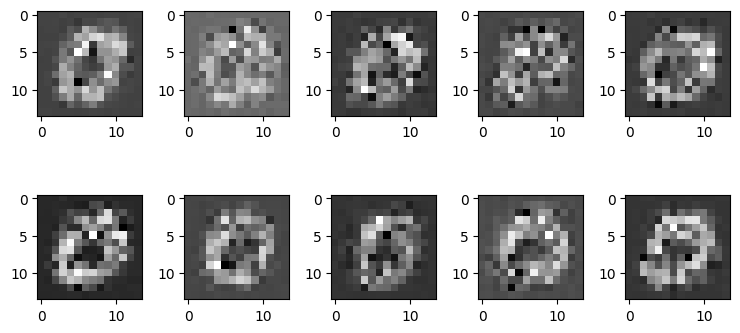

Epoch 51: Train Loss:666.7546503594581 Val BPD: 4.941699028015137


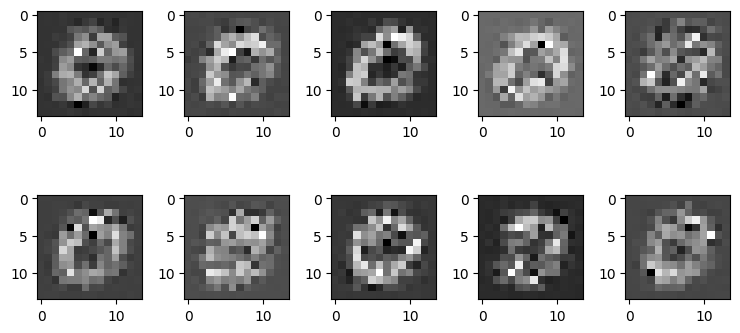

Epoch 61: Train Loss:644.6686518243018 Val BPD: 4.786136150360107


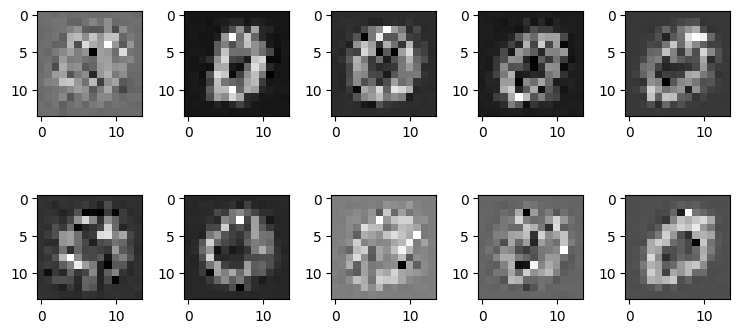

Epoch 71: Train Loss:626.9345794028425 Val BPD: 4.685118198394775


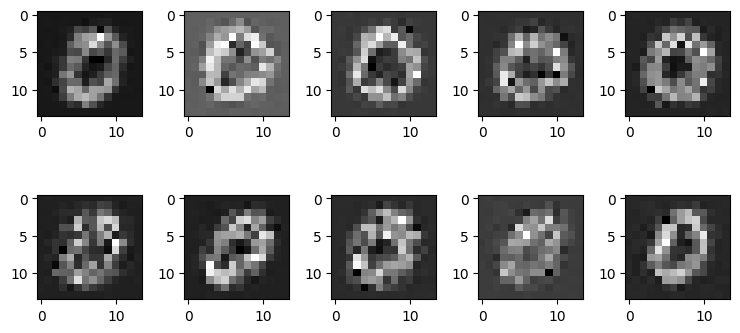

Epoch 81: Train Loss:611.2021224650931 Val BPD: 4.565698146820068


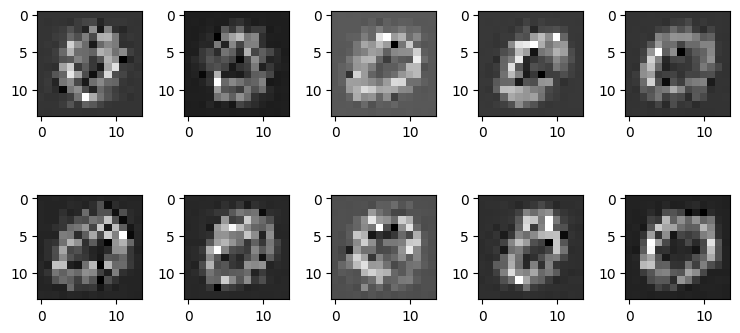

Epoch 91: Train Loss:598.5557134100732 Val BPD: 4.488025665283203


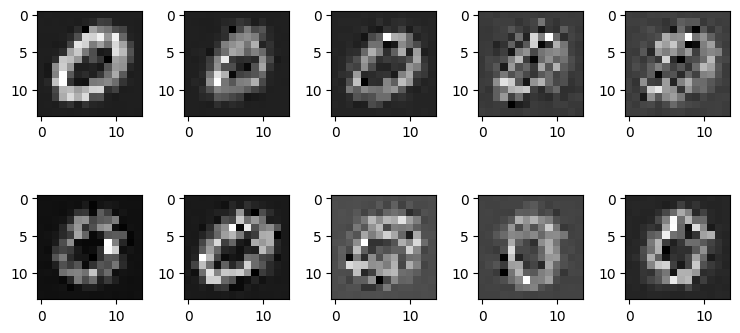

Epoch 101: Train Loss:589.1627625810339 Val BPD: 4.397255897521973


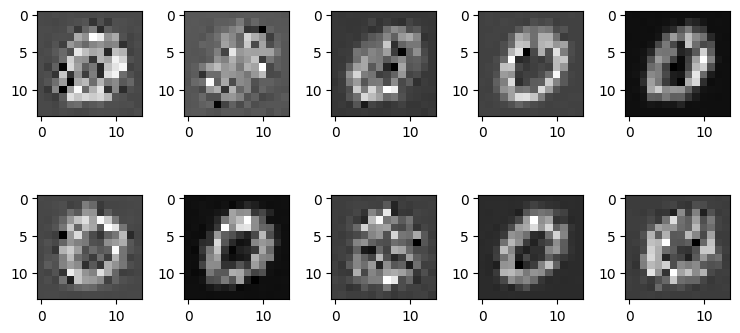

Epoch 111: Train Loss:577.4221139461437 Val BPD: 4.304437637329102


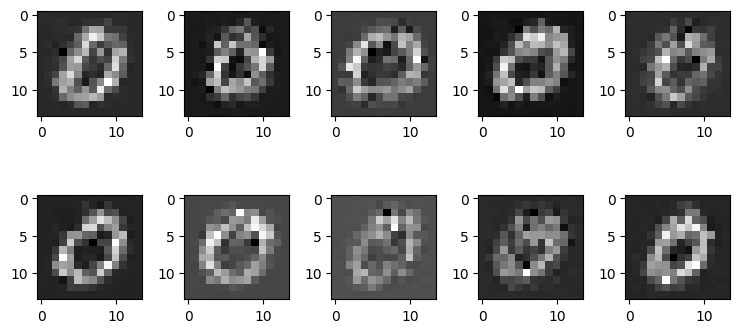

Epoch 121: Train Loss:568.6663013214761 Val BPD: 4.23905086517334


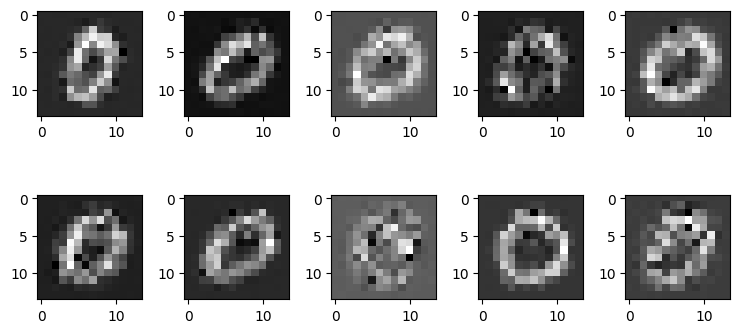

Epoch 131: Train Loss:559.3913807970413 Val BPD: 4.165648460388184


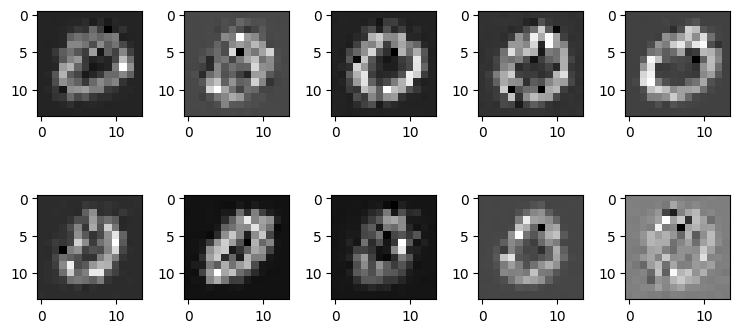

Epoch 141: Train Loss:552.3135635700631 Val BPD: 4.11665153503418


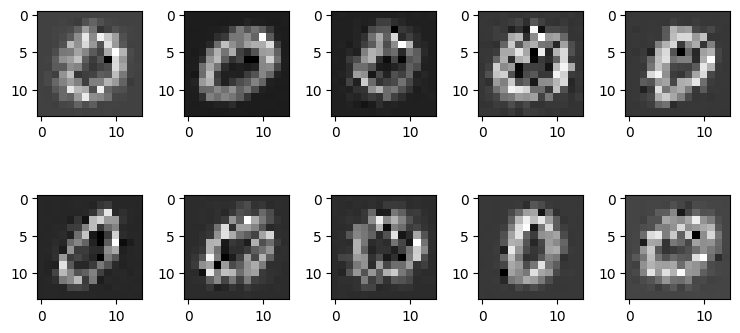

Epoch 151: Train Loss:545.109307471742 Val BPD: 4.077591896057129


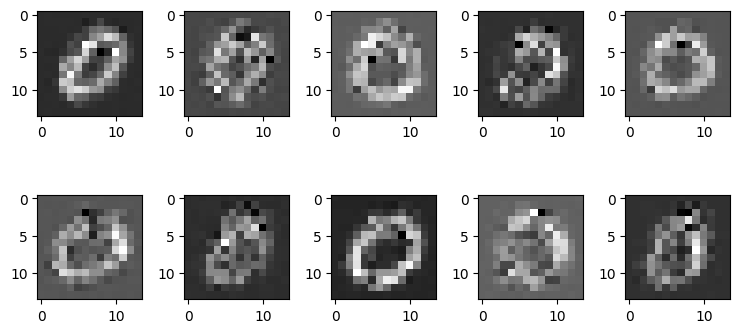

Epoch 161: Train Loss:538.3799828062666 Val BPD: 4.028104782104492


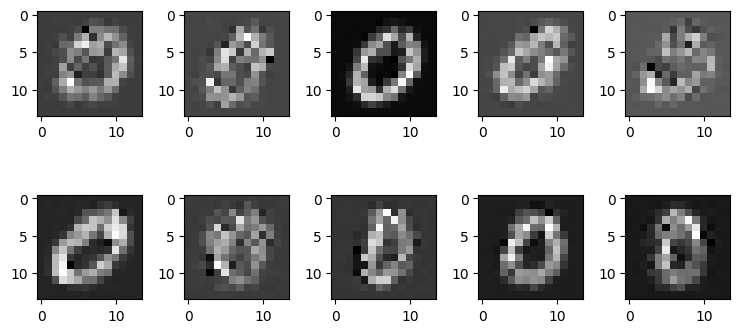

Epoch 171: Train Loss:532.8164971534242 Val BPD: 4.01011848449707


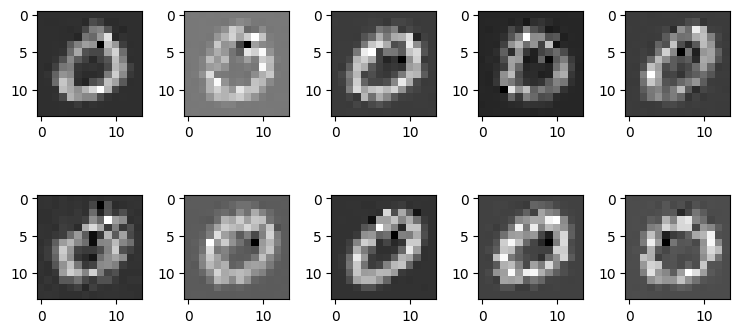

Epoch 181: Train Loss:527.5143101468999 Val BPD: 3.9720377922058105


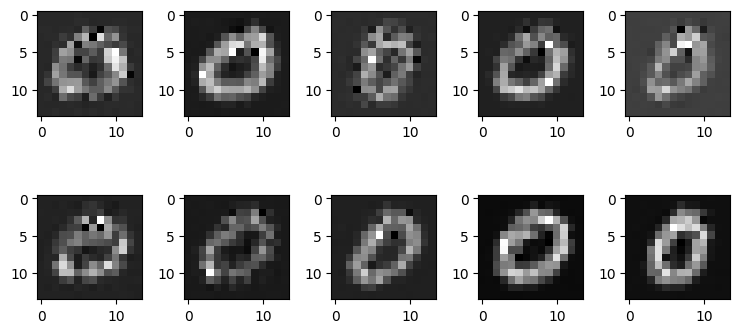

Epoch 191: Train Loss:523.0489547404837 Val BPD: 3.932159185409546


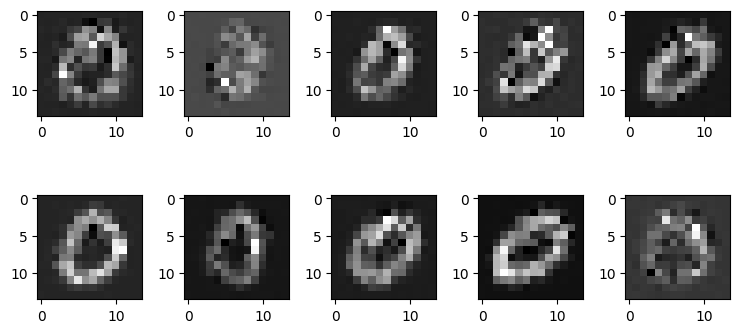

Epoch 201: Train Loss:518.3885108460771 Val BPD: 3.9126644134521484


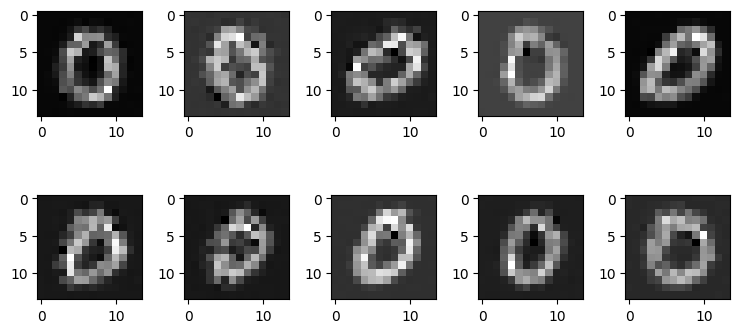

Epoch 211: Train Loss:514.9165779276098 Val BPD: 3.8738627433776855


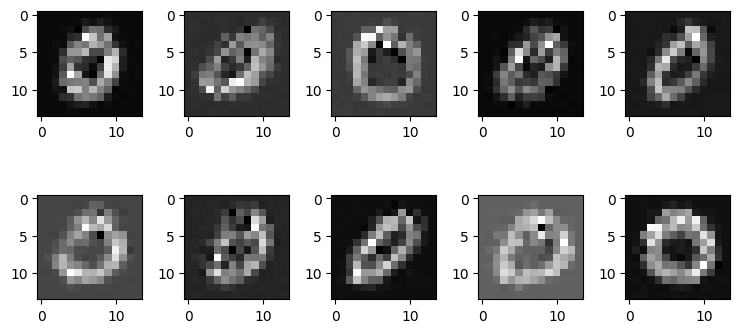

Epoch 221: Train Loss:510.7528718988946 Val BPD: 3.853271245956421


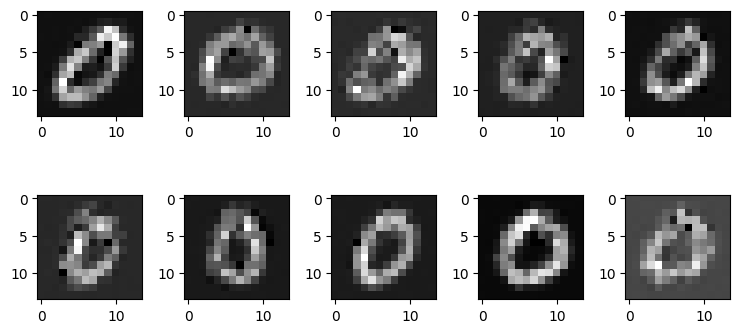

Epoch 231: Train Loss:507.70713254238694 Val BPD: 3.8431038856506348


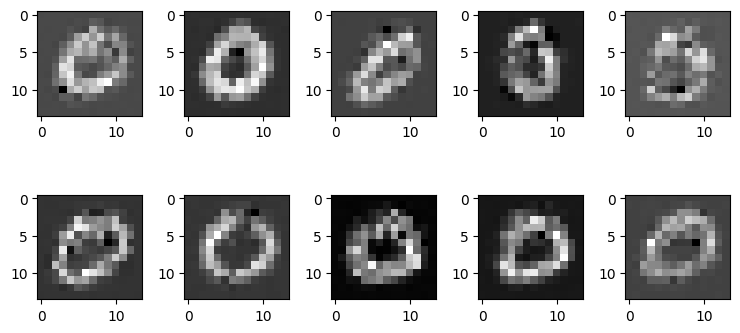

Epoch 241: Train Loss:504.0963972375748 Val BPD: 3.821185350418091


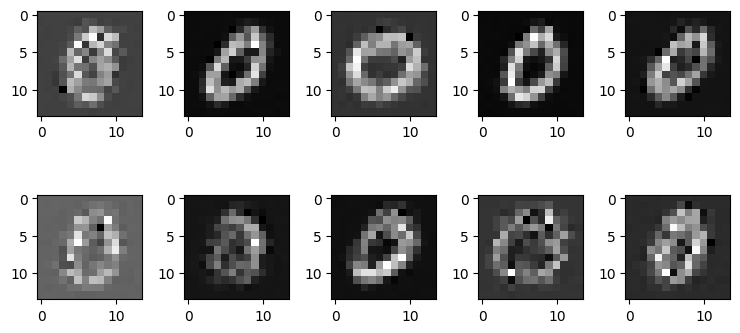

Epoch 251: Train Loss:501.0599274330951 Val BPD: 3.7920656204223633


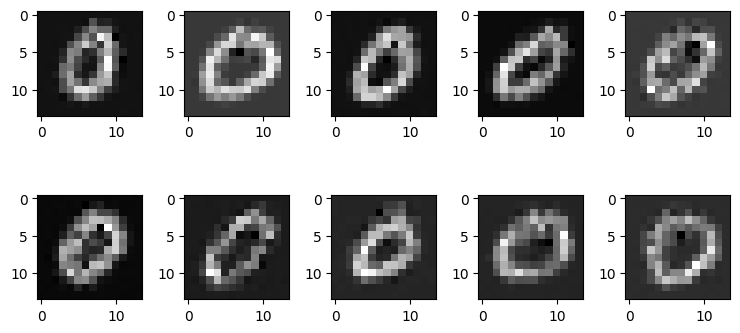

Epoch 261: Train Loss:497.89991597926365 Val BPD: 3.7775046825408936


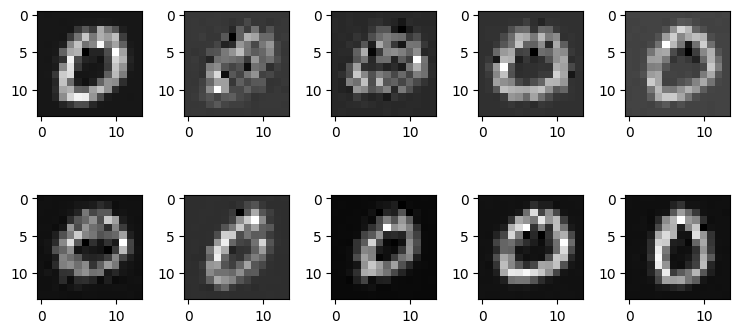

Epoch 271: Train Loss:495.63456628677693 Val BPD: 3.755519390106201


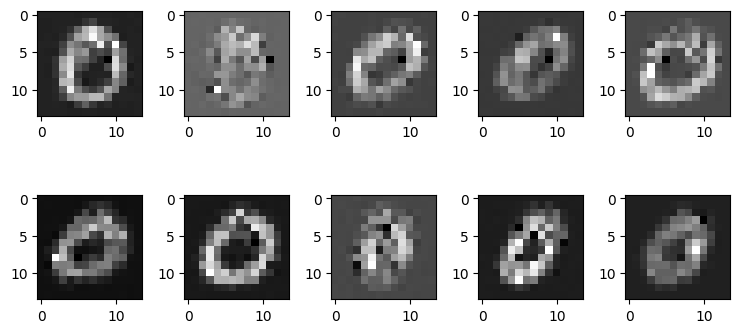

Epoch 281: Train Loss:492.7165014388713 Val BPD: 3.7659480571746826


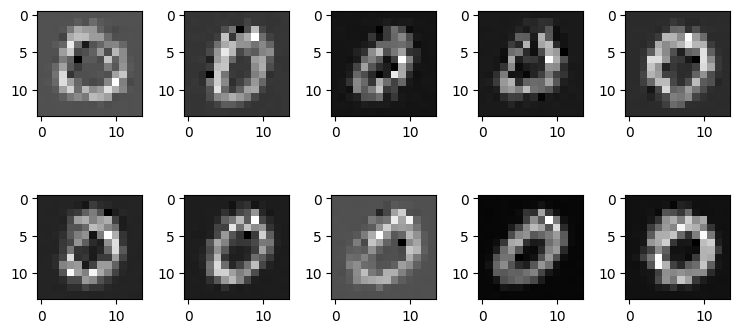

Epoch 291: Train Loss:489.9706050791639 Val BPD: 3.73612117767334


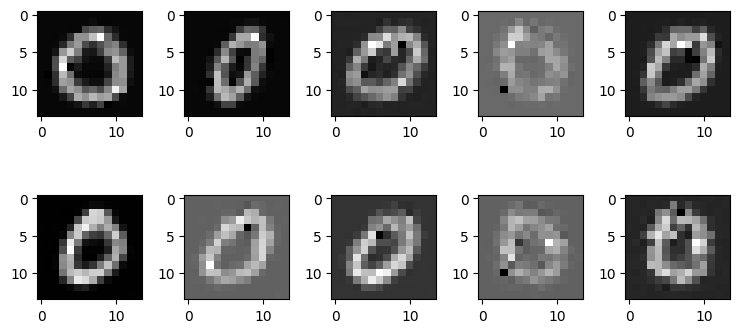

Epoch 301: Train Loss:488.05892359956783 Val BPD: 3.71110200881958


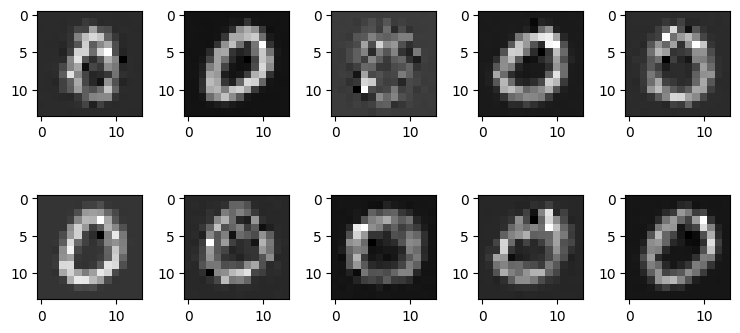

Epoch 311: Train Loss:485.75924098238033 Val BPD: 3.704138994216919


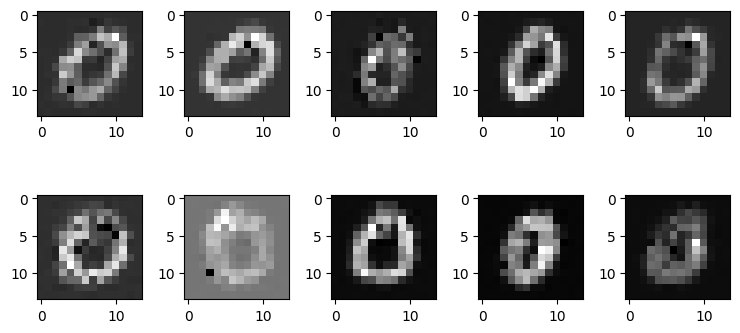

Epoch 321: Train Loss:483.5778490431765 Val BPD: 3.7041242122650146


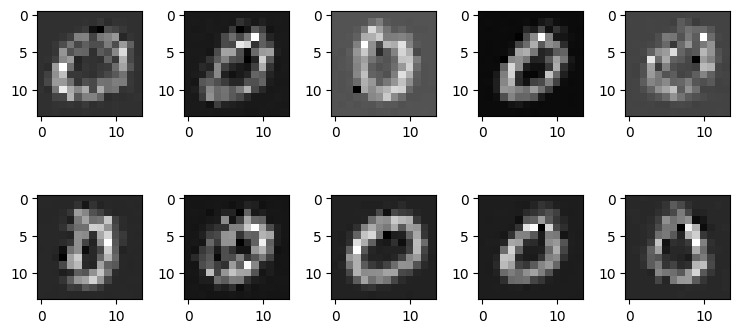

Epoch 331: Train Loss:481.61583303897936 Val BPD: 3.6733179092407227


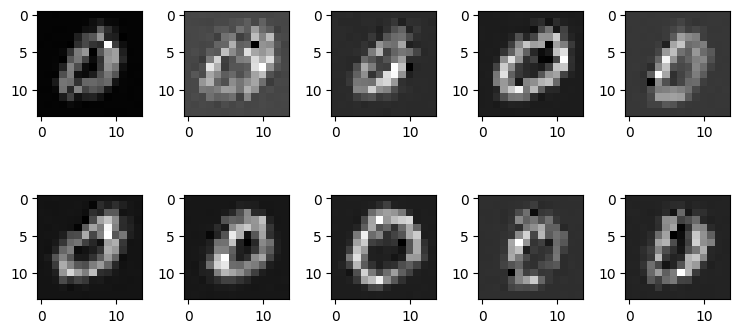

Epoch 341: Train Loss:479.40735512591425 Val BPD: 3.6707043647766113


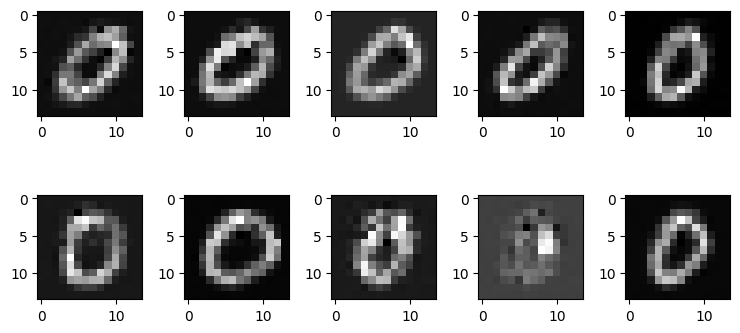

Epoch 351: Train Loss:477.34094887591425 Val BPD: 3.6540679931640625


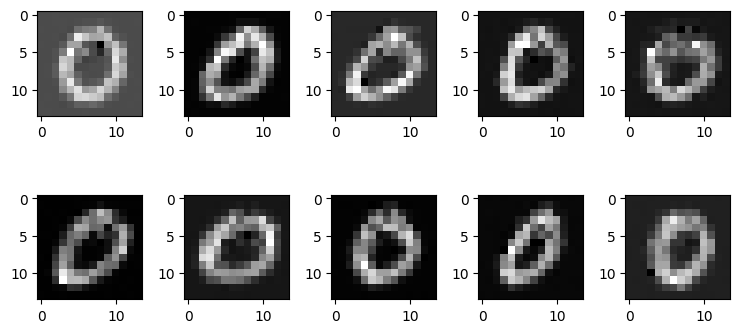

Epoch 361: Train Loss:475.1940560848155 Val BPD: 3.6494829654693604


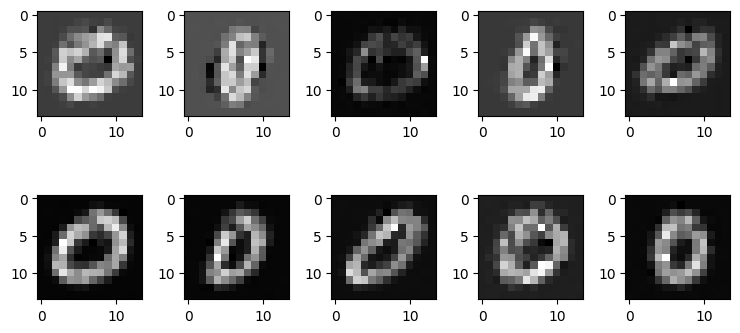

Epoch 371: Train Loss:473.96223352310506 Val BPD: 3.646225929260254


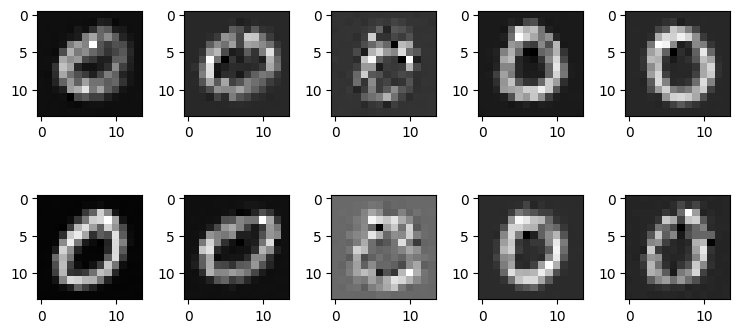

Epoch 381: Train Loss:471.71419703706783 Val BPD: 3.6392953395843506


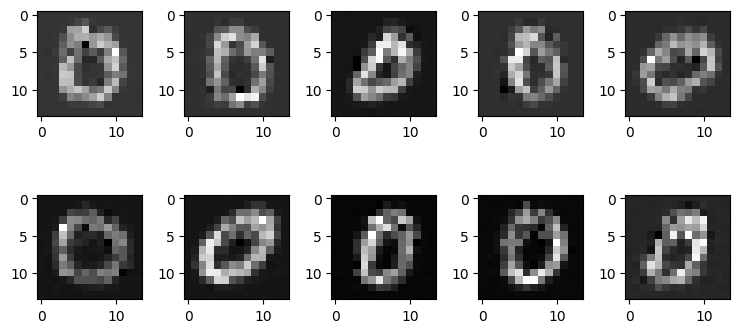

Epoch 391: Train Loss:470.4321977331283 Val BPD: 3.6206531524658203


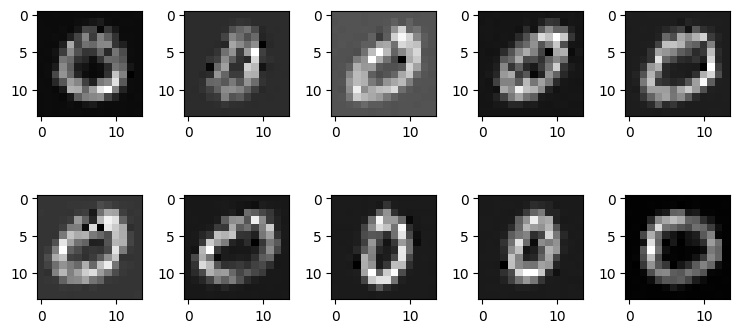

Epoch 401: Train Loss:468.55881711269944 Val BPD: 3.6087851524353027


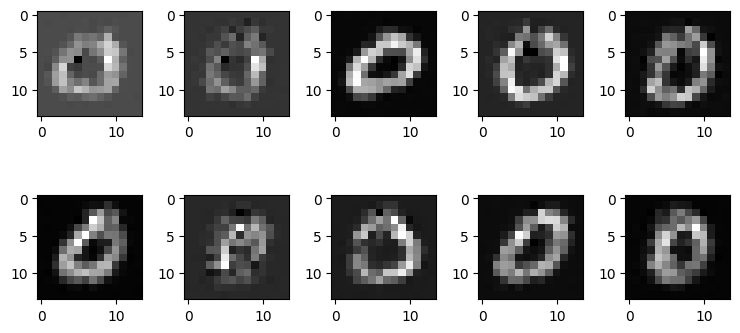

Epoch 411: Train Loss:466.58151504841254 Val BPD: 3.5975914001464844


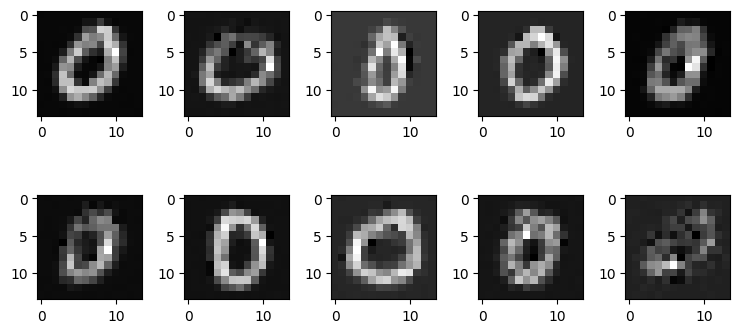

Epoch 421: Train Loss:465.3038576815991 Val BPD: 3.6029212474823


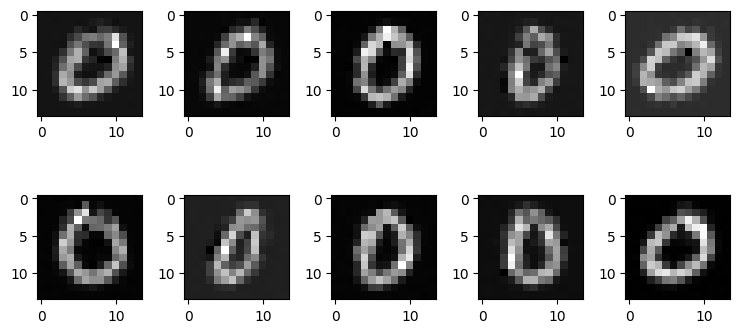

Epoch 431: Train Loss:463.59655631856714 Val BPD: 3.587956428527832


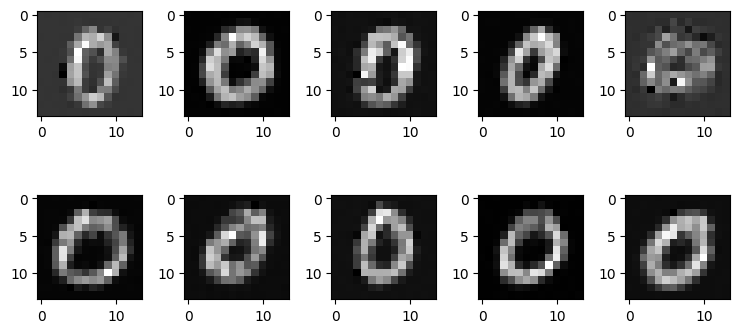

Epoch 441: Train Loss:462.17306064037564 Val BPD: 3.591953754425049


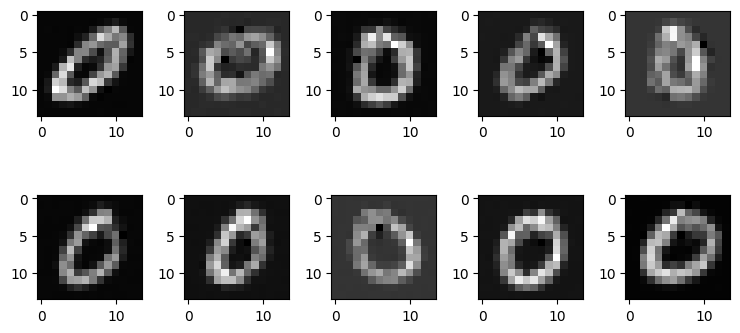

Epoch 451: Train Loss:460.9711414093667 Val BPD: 3.5590546131134033


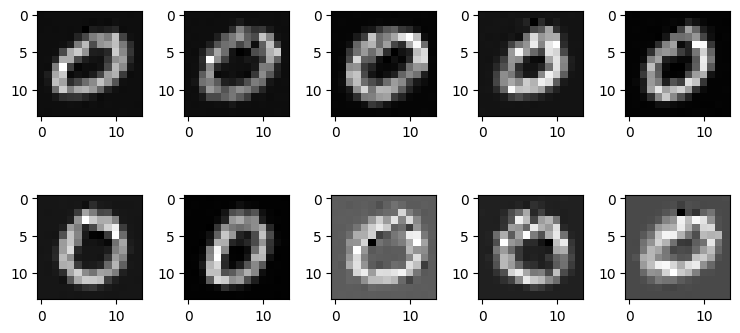

Epoch 461: Train Loss:459.8919482941323 Val BPD: 3.551848888397217


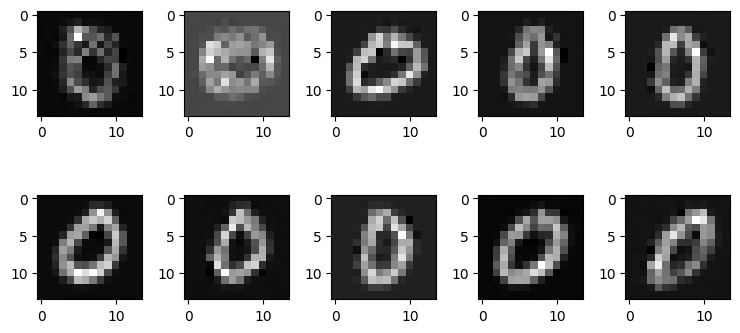

Epoch 471: Train Loss:458.3412176903258 Val BPD: 3.5697078704833984


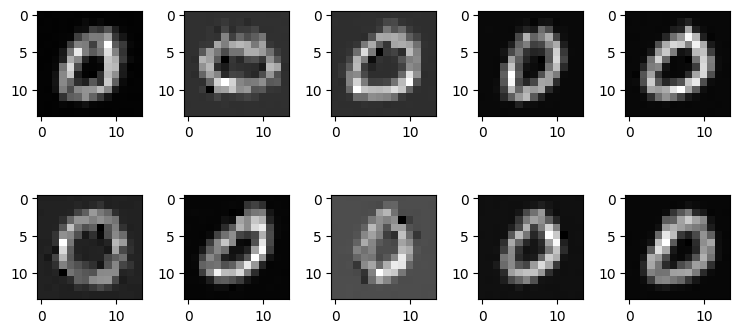

Epoch 481: Train Loss:456.95568198346075 Val BPD: 3.5447936058044434


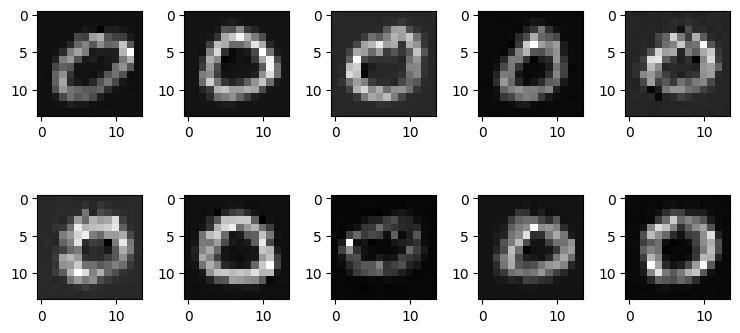

Epoch 491: Train Loss:455.82226822224067 Val BPD: 3.5577216148376465


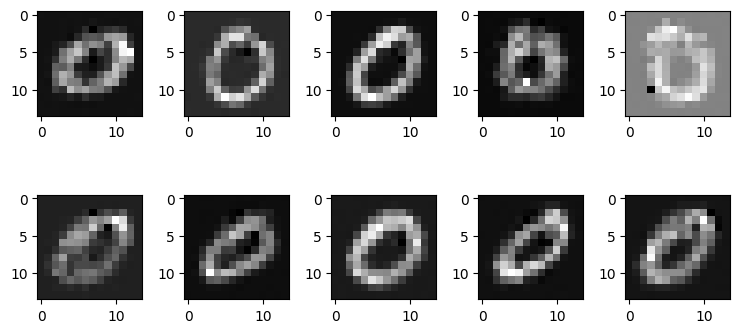

Epoch 501: Train Loss:454.6220047321725 Val BPD: 3.5799286365509033


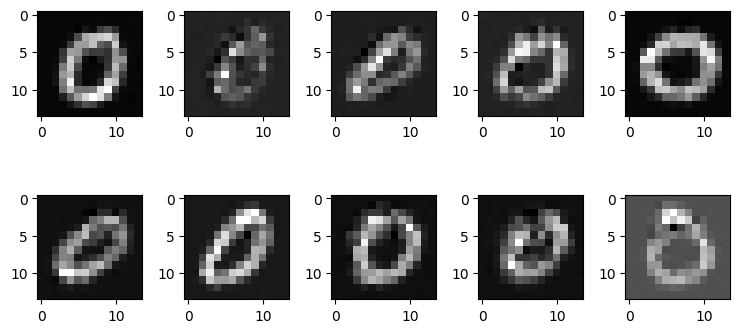

Epoch 511: Train Loss:453.571150110123 Val BPD: 3.5626041889190674


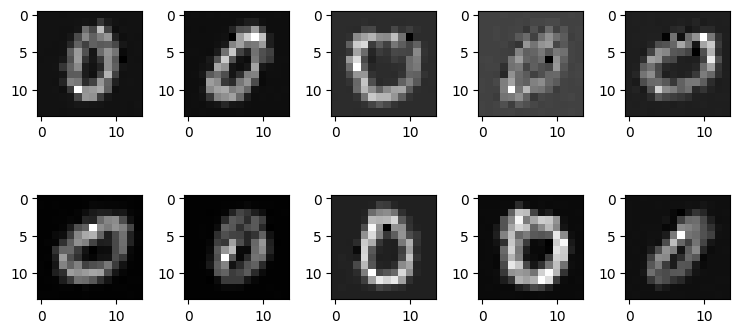

Epoch 521: Train Loss:452.51304853723406 Val BPD: 3.52900767326355


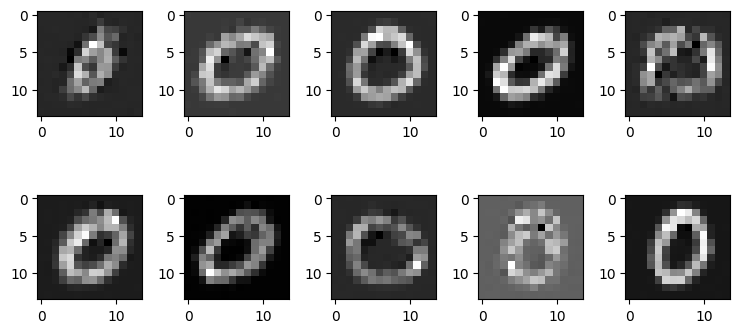

Epoch 531: Train Loss:451.39011853806517 Val BPD: 3.504124879837036


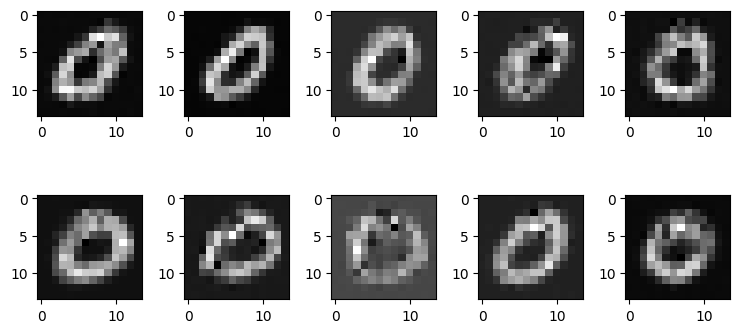

Epoch 541: Train Loss:450.0508383892952 Val BPD: 3.55415678024292


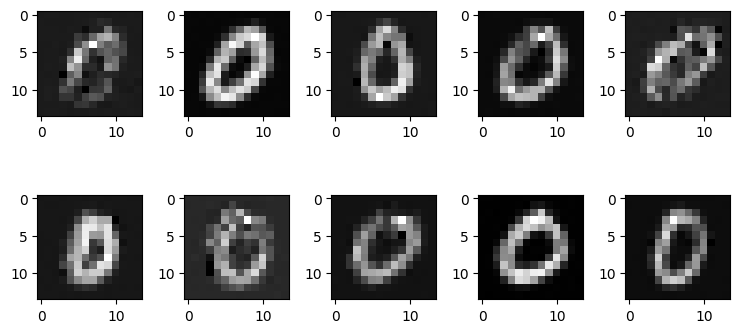

Epoch 551: Train Loss:449.1301535748421 Val BPD: 3.5297913551330566


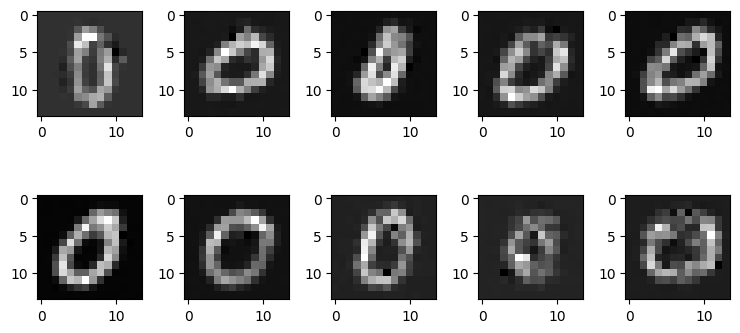

Epoch 561: Train Loss:448.34105796002325 Val BPD: 3.510409355163574


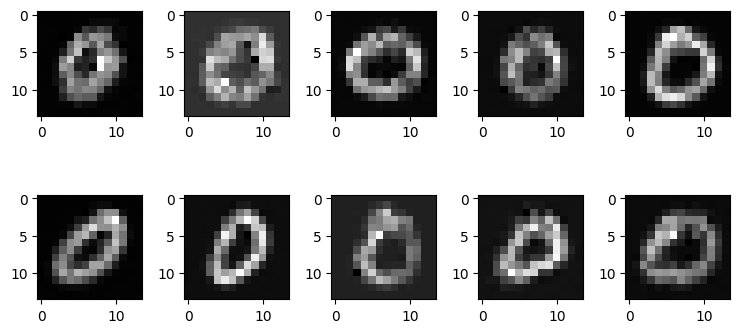

Epoch 571: Train Loss:447.20930383560506 Val BPD: 3.5105972290039062


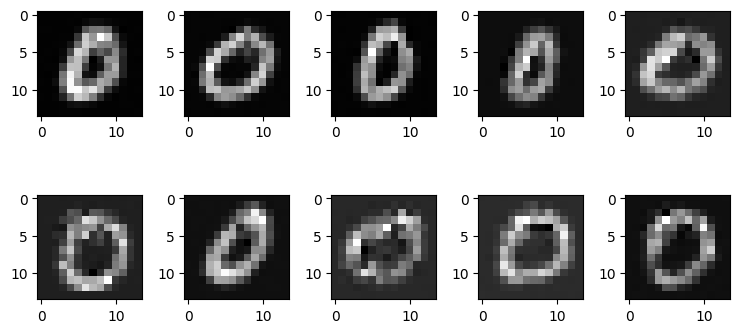

Epoch 581: Train Loss:446.30195000831117 Val BPD: 3.4998395442962646


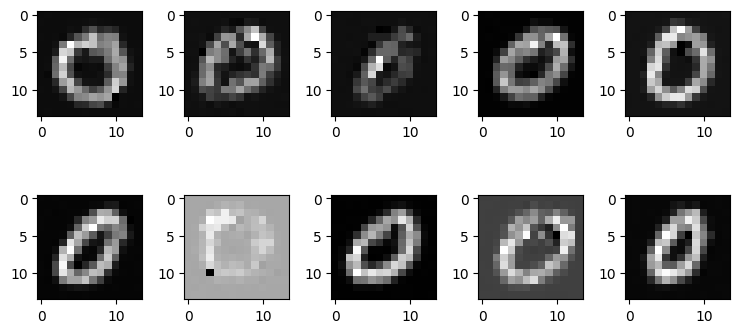

Epoch 591: Train Loss:445.0923221669299 Val BPD: 3.5091054439544678


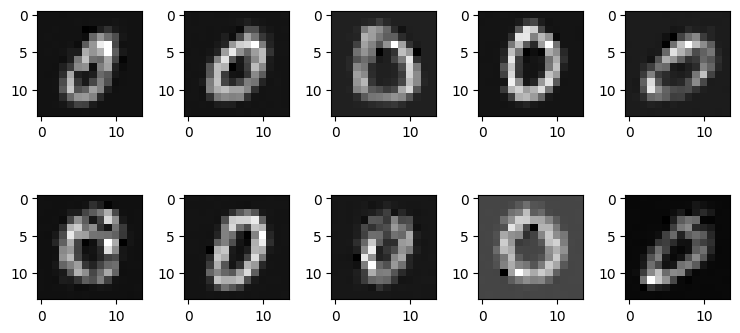

Epoch 601: Train Loss:444.26614574675864 Val BPD: 3.4883902072906494


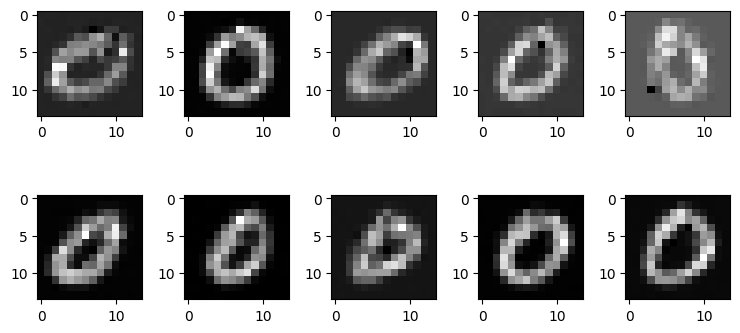

Epoch 611: Train Loss:443.4852963711353 Val BPD: 3.504082441329956


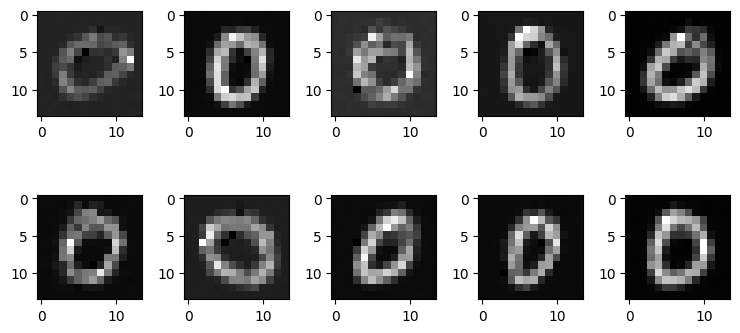

Epoch 621: Train Loss:442.4968664291057 Val BPD: 3.4850564002990723


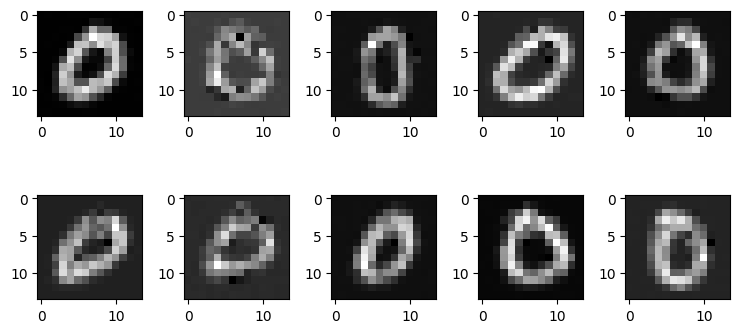

Epoch 631: Train Loss:441.6965169703707 Val BPD: 3.520287275314331


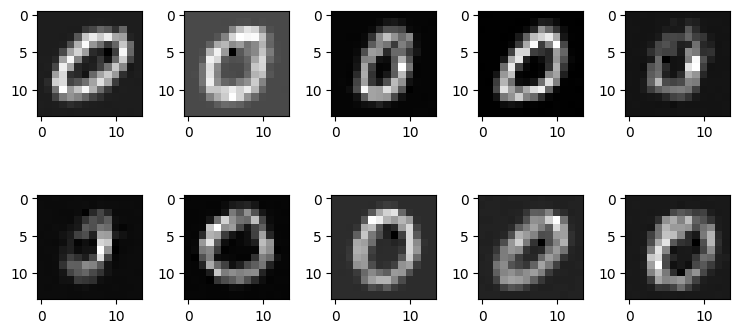

Epoch 641: Train Loss:441.2478663667719 Val BPD: 3.52728009223938


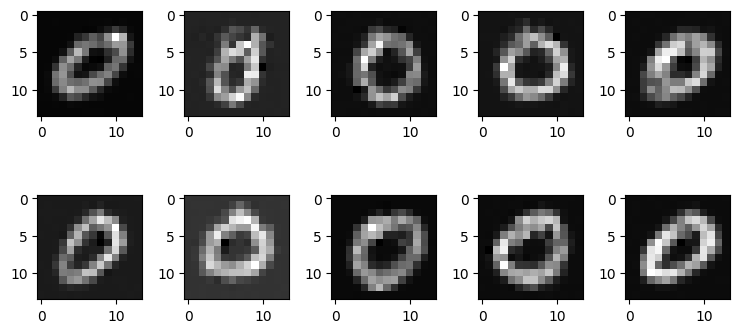

Epoch 651: Train Loss:440.1418353141622 Val BPD: 3.4900972843170166


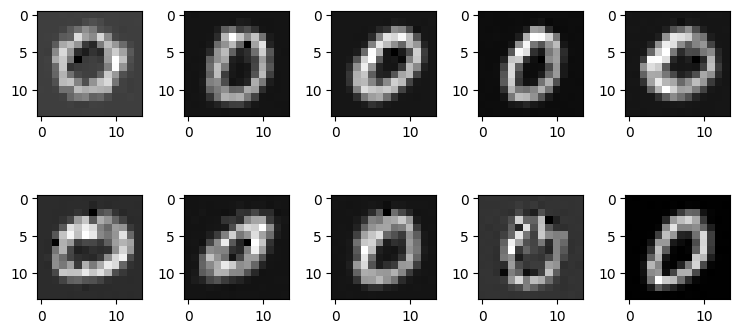

Epoch 661: Train Loss:439.22266079517124 Val BPD: 3.5463123321533203


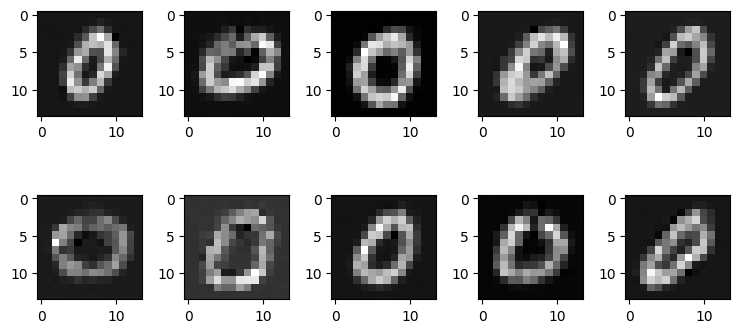

Epoch 671: Train Loss:439.02057079558676 Val BPD: 3.4524097442626953


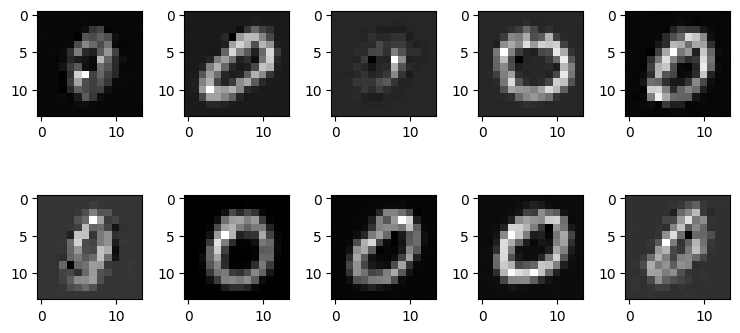

Epoch 681: Train Loss:437.71951034221246 Val BPD: 3.489079236984253


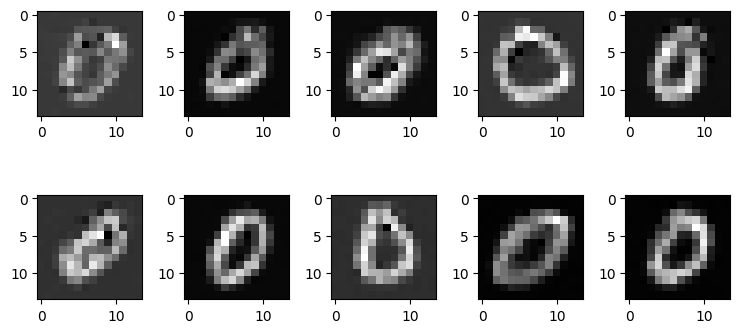

Epoch 691: Train Loss:436.8854623348155 Val BPD: 3.4545748233795166


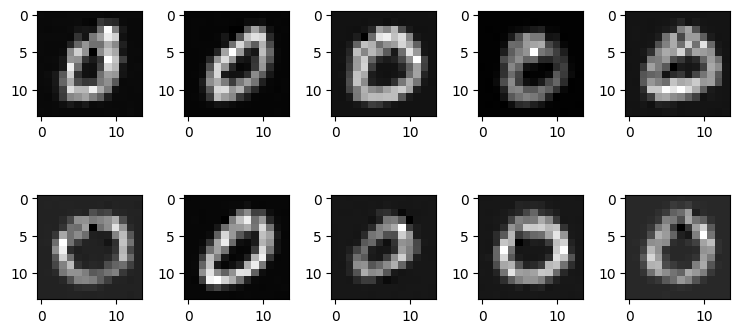

Epoch 701: Train Loss:436.3965272294714 Val BPD: 3.511881113052368


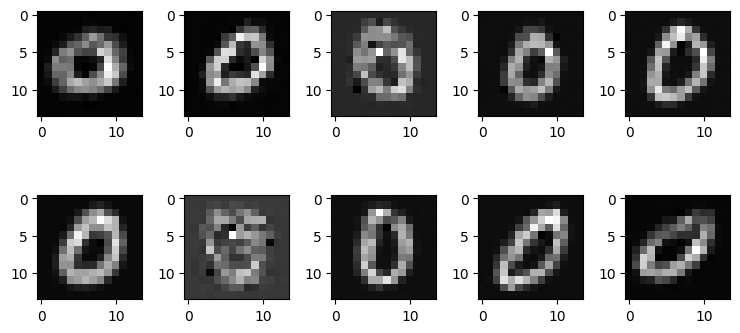

Epoch 711: Train Loss:435.6129027021692 Val BPD: 3.493905544281006


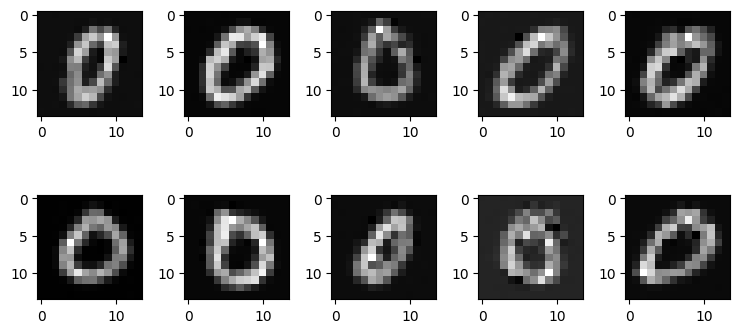

Epoch 721: Train Loss:435.08598425033244 Val BPD: 3.4793543815612793


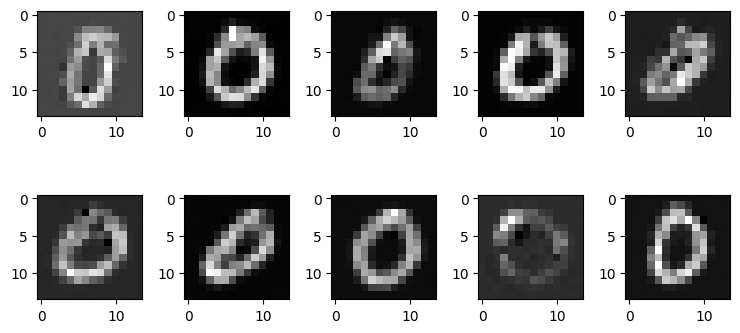

Epoch 731: Train Loss:434.36096256337265 Val BPD: 3.476790428161621


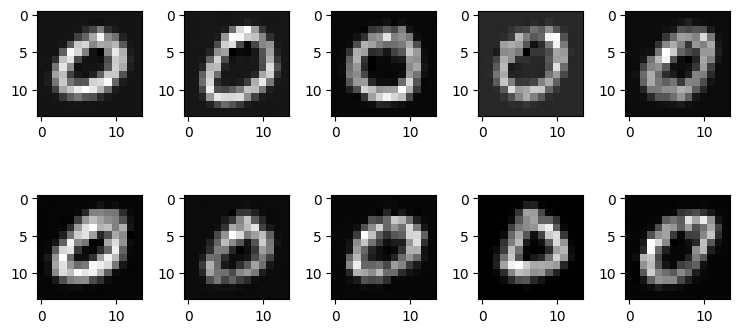

Epoch 741: Train Loss:433.6998505287982 Val BPD: 3.4738271236419678


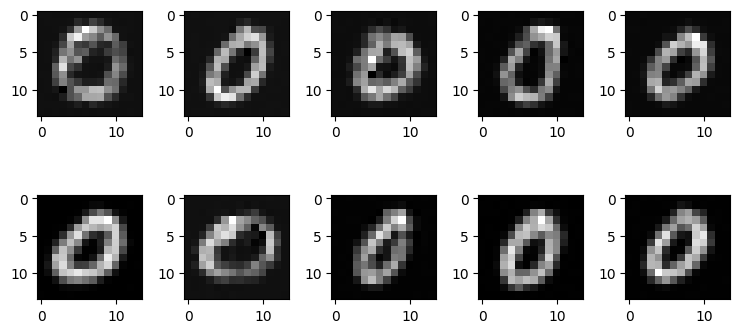

Epoch 751: Train Loss:433.25417571372174 Val BPD: 3.5040340423583984


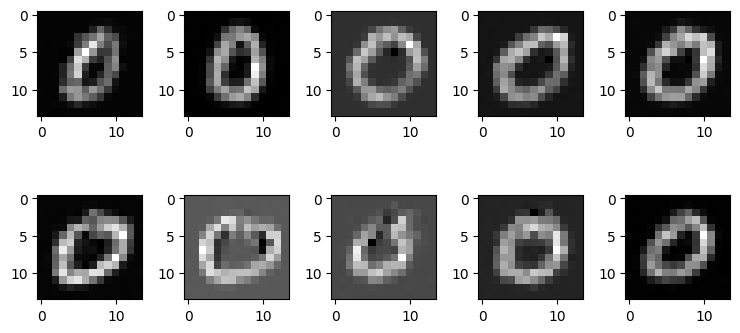

Epoch 761: Train Loss:432.38854331158575 Val BPD: 3.4468462467193604


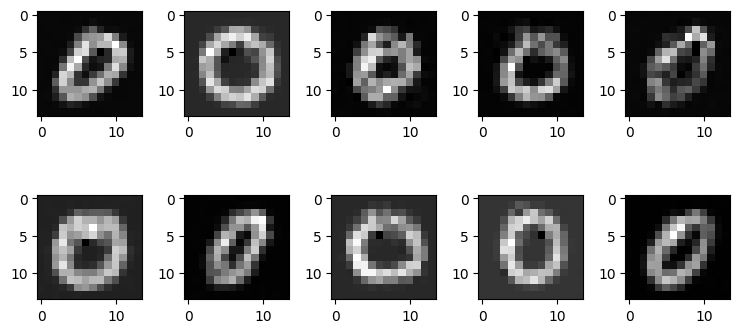

Epoch 771: Train Loss:431.56529787753493 Val BPD: 3.4755687713623047


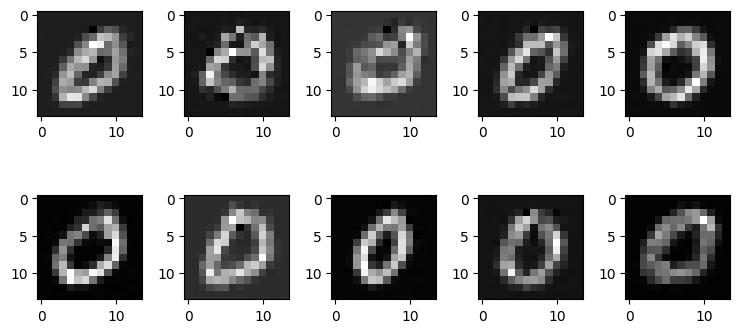

Epoch 781: Train Loss:431.10039049513796 Val BPD: 3.4962551593780518


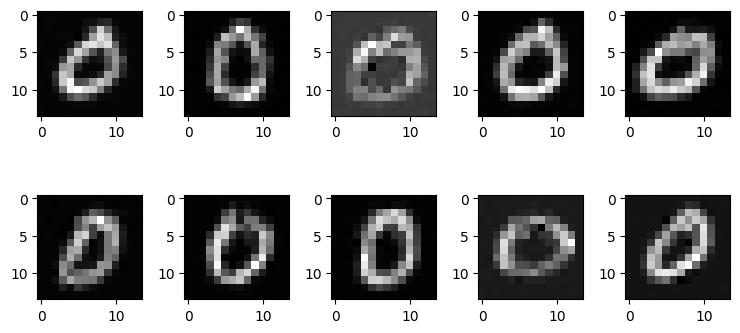

Epoch 791: Train Loss:430.6686096191406 Val BPD: 3.472910165786743


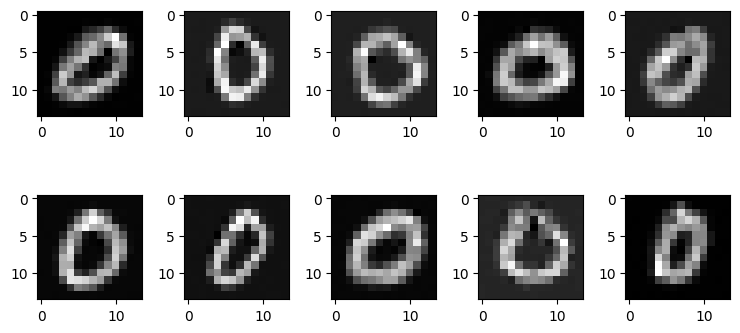

Epoch 801: Train Loss:429.67786293841425 Val BPD: 3.542323350906372


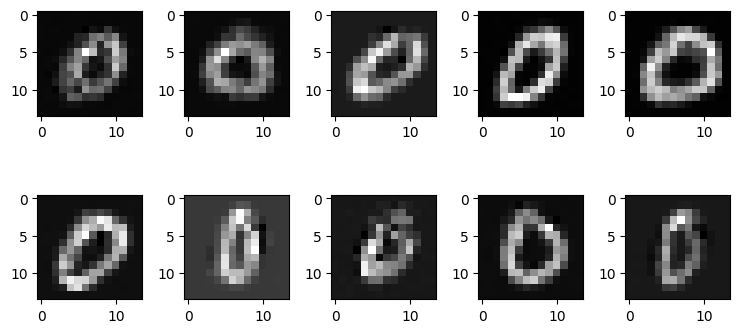

Epoch 811: Train Loss:429.0680405637051 Val BPD: 3.5015556812286377


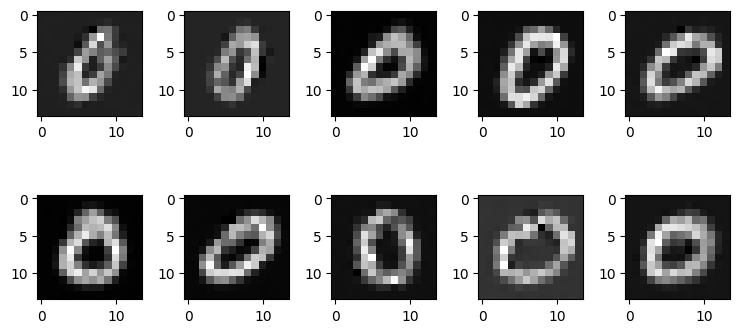

Epoch 821: Train Loss:428.68121337890625 Val BPD: 3.513697385787964


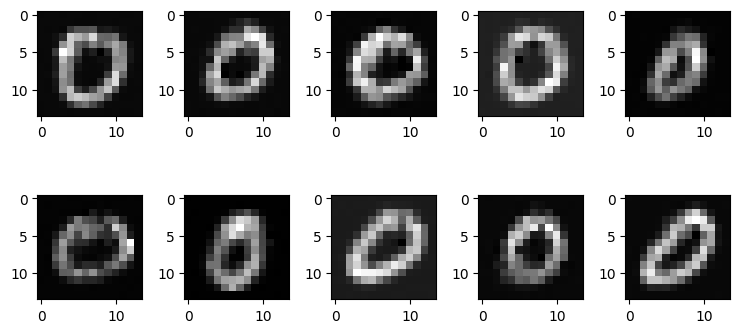

Epoch 831: Train Loss:427.96252571268286 Val BPD: 3.4952847957611084


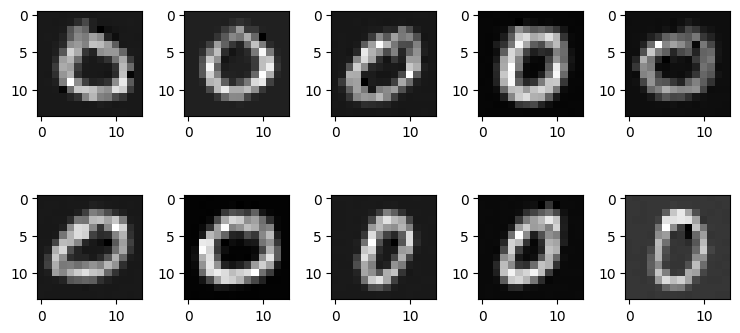

Epoch 841: Train Loss:427.42290740317486 Val BPD: 3.5725488662719727


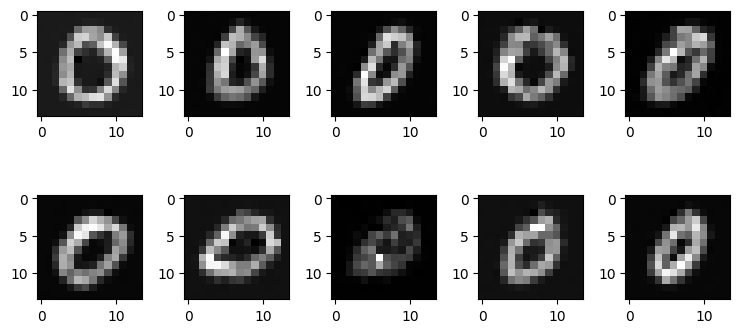

Epoch 851: Train Loss:427.425604637633 Val BPD: 3.5303516387939453


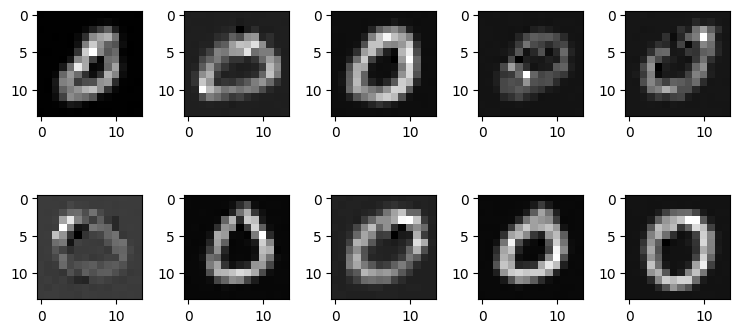

Epoch 861: Train Loss:426.72551581200133 Val BPD: 3.5309107303619385


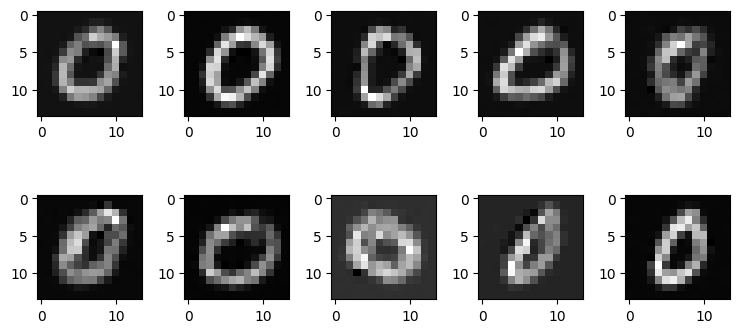

Epoch 871: Train Loss:426.1139825049867 Val BPD: 3.543994903564453


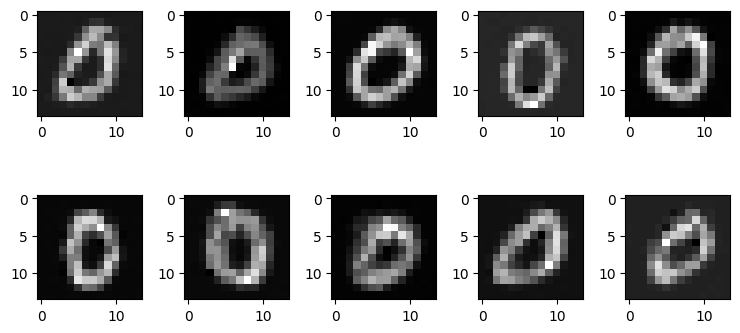

Epoch 881: Train Loss:425.66783499210436 Val BPD: 3.556367874145508


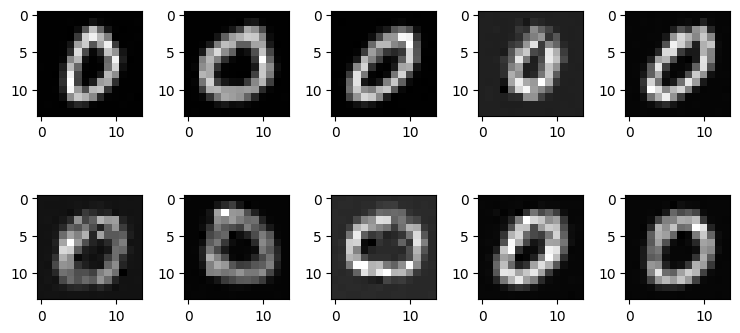

Epoch 891: Train Loss:425.1920503656915 Val BPD: 3.5430667400360107


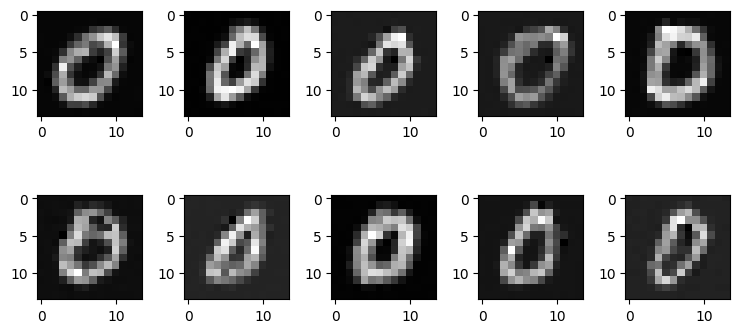

Epoch 901: Train Loss:424.8101683271692 Val BPD: 3.5561530590057373


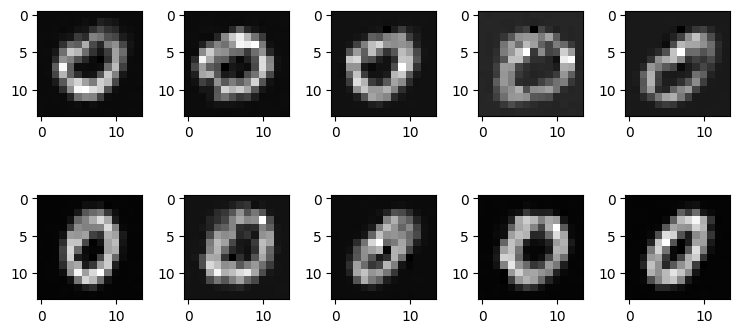

Epoch 911: Train Loss:424.18955311876664 Val BPD: 3.6914877891540527


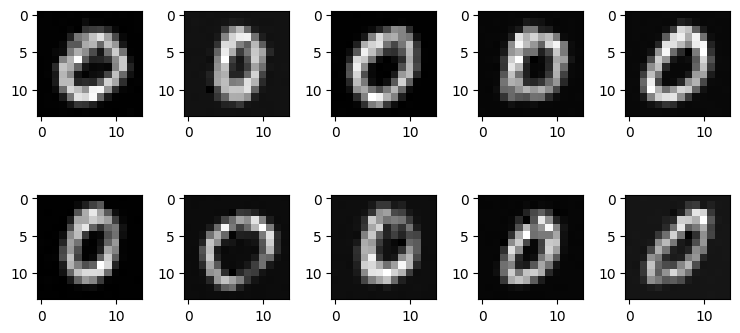

Epoch 921: Train Loss:423.82787501558346 Val BPD: 3.580230474472046


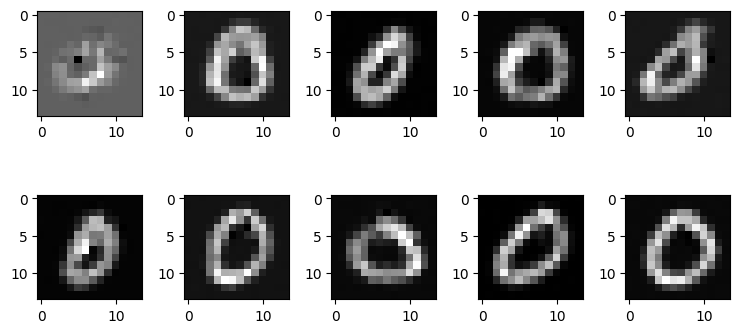

Epoch 931: Train Loss:423.0335459607713 Val BPD: 3.920441150665283


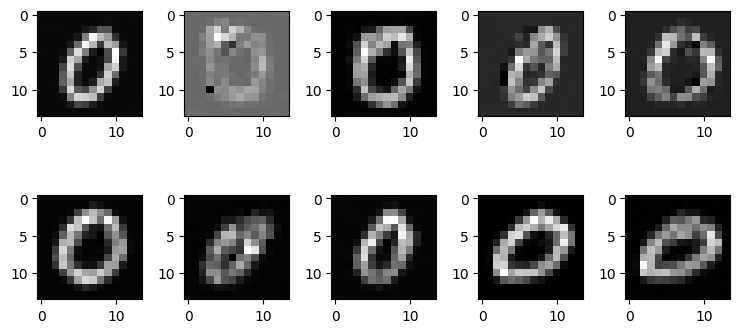

Epoch 941: Train Loss:422.7683488561752 Val BPD: 3.7309534549713135


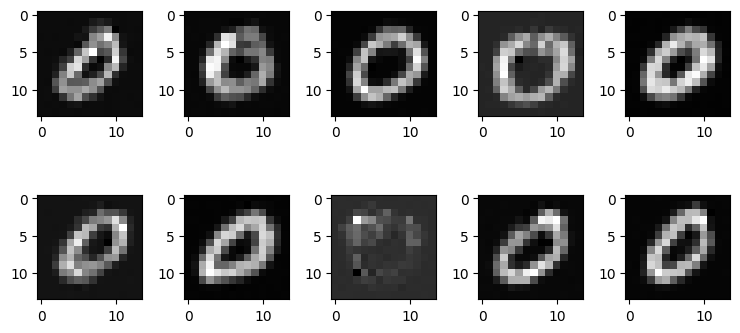

Epoch 951: Train Loss:421.8764362741024 Val BPD: 3.9104018211364746


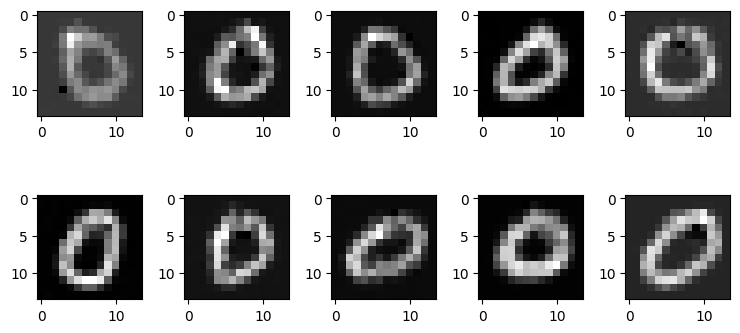

Epoch 961: Train Loss:421.86167940180354 Val BPD: 3.931047201156616


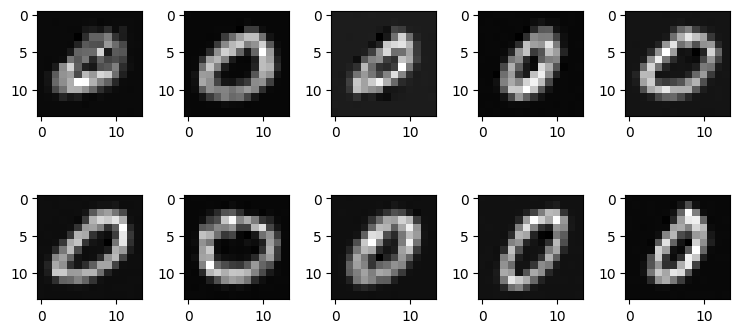

Epoch 971: Train Loss:421.13549739756485 Val BPD: 3.921098232269287


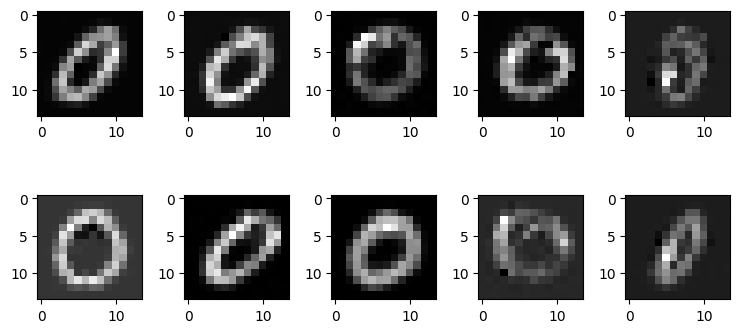

Epoch 981: Train Loss:420.6075030387716 Val BPD: 4.06805419921875


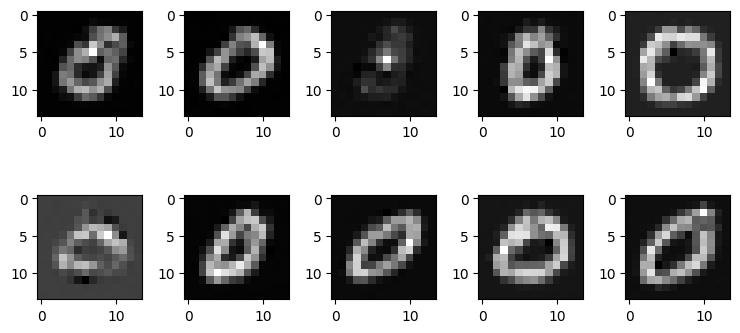

Epoch 991: Train Loss:420.2147054469332 Val BPD: 3.8068857192993164


In [203]:
device = 'cuda'
flow = RealNVP(14*14, num_steps=21).to(device)
optim = torch.optim.AdamW(flow.parameters(), lr=1e-5)
epochs = 1000
bits = 8
for ep in range(epochs):
    total_loss = 0.
    iters = 0
    for x, _ in train_loader:
        x = (x * 255).long()
        u = torch.rand_like(x.float())
        x = x + u
        x = x / (2 ** bits)
        x = x.flatten(start_dim=1)

        optim.zero_grad()
        log_px = flow.log_prob(x.to(device)) - np.log((2 ** bits)) * (14 * 14)
        loss = - (log_px).mean()
        loss.backward()
        optim.step()
        iters += 1
        total_loss += loss.item()
    if ep % 10 == 0:
        with torch.no_grad():
            val_iters = 0
            total_bpd = 0.
            for x, _ in test_loader:
                x = (x * 255).long()
                u = torch.rand_like(x.float())
                x = x + u
                x = x / (2 ** bits)
                x = x.flatten(start_dim=1)
                log_px = flow.log_prob(x.to(device)) - np.log((2 ** bits)) * (14 * 14)
                bpd = -(log_px).mean().cpu() / (np.log(2) * (14 * 14))
                total_bpd += bpd
                val_iters += 1
        samples = flow.sample(10).detach().cpu()
        samples = torch.unflatten(samples, dim=1, sizes=(14, 14)).unsqueeze(1)

        plot_mnist(samples[:, 0], 2, 5)

        print(f"Epoch {ep+1}: Train Loss:{total_loss / iters} Val BPD: {total_bpd / val_iters}")

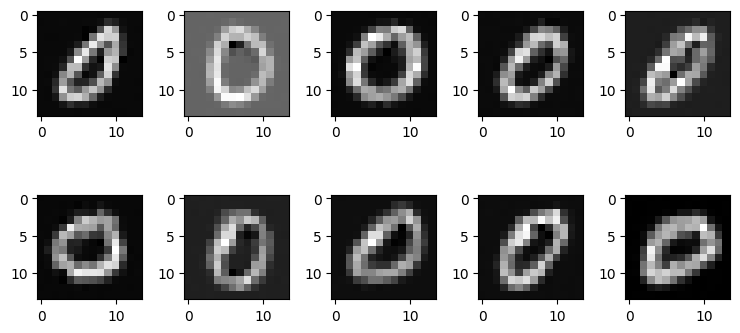

In [204]:
samples = flow.sample(10).detach().cpu()
samples = torch.unflatten(samples, dim=1, sizes=(14, 14)).unsqueeze(1)
plot_mnist(samples[:,0], 2, 5)

## Bonus zadatak

Predložite implementaciju konvolucijskog normalizirajućeg toka.